#**Importing libraries**

In [1]:
import math
import io
import os
from collections import namedtuple
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import tree
from tqdm import tqdm
import operator
import pandas as pd

!pip install tf-keras-vis

from tensorflow.keras import backend as K
import time
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, InputLayer
from tensorflow.keras.layers import Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus

from tf_keras_vis.utils import normalize

import matplotlib.pyplot as plt



import math

from collections import namedtuple
import sys

import operator

import copy

import keras
import argparse

from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
#from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.models import Model, load_model
from keras import optimizers, regularizers
from keras import backend as K
import pickle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 852.5 kB/s eta 0:00:00


In [2]:
#!python
!pip3 install -U pybind11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 4.0 MB/s eta 0:00:00


#**Load model and input data for MNIST**

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

!wget https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/mnist_cnn.h5 -O ./mnist_cnn.h5

print('Loading the model:')
model=load_model('mnist_cnn.h5')
print("Printing summary of the model:")
model.summary()

11490434/11490434 [==============================] - 1s 0us/step
--2023-09-25 15:01:36--  https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/mnist_cnn.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 940648 (919K) [application/octet-stream]
Saving to: ‘./mnist_cnn.h5’

./mnist_cnn.h5      100%[===================>] 918.60K  4.72MB/s    in 0.2s    

2023-09-25 15:01:37 (4.72 MB/s) - ‘./mnist_cnn.h5’ saved [940648/940648]

Loading the model:
Printing summary of the model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 2)         20        
                                                      

In [4]:
print("Dense Layers Close to The Output")
layer_name = 'dense_1'
lay = model.get_layer(layer_name)
print(lay.name)
#print(lay.weights)
#print(lay.bias)
#print(lay.activation)

layer_name = 'activation_3'
lay = model.get_layer(layer_name)
print(lay.name)
#print(lay.activation)

layer_name = 'dense_2'
lay = model.get_layer(layer_name)
print(lay.name)
#print(lay.weights)
#print(lay.bias)
#print(lay.activation)


Dense Layers Close to The Output
dense_1
activation_3
dense_2


#**Rule Extraction from each of the Dense Layers Close to the output**

**Each rule is of the form pre(x) => P(F(x)), pre: neuron constraints at the chosen layer. P is a property of the output of model.**

*P can be any output property for classification or regression. The example shown here are for correct and incorrect classification.*

**Rules for correct classification: P(F(x)) is true iff F(x) = L and L = L_ideal.**
**Seperate rules extracted for each of the 10 labels.**

**Rules for incorrect classification: P(F(x)) is true iff F(x) != L_ideal.**



##**Create Labels Dataset for Train Data, and Test Data**

Label = model output for correctly classified inputs,
Label = 1000 for mis-classified inputs.

In [5]:
labels = []
train_labels = (model.predict(x_train)).argmax(axis=1)
print("ACTUAL TRAIN LABELS:", train_labels.shape)
PASS = 0
FAIL = 0
for indx in range(0,len(train_labels)):
  if (train_labels[indx] == y_train[indx]):
    PASS = PASS + 1
    labels.append(train_labels[indx])
  else:
    FAIL = FAIL + 1
    labels.append(1000) #Misclassified
print("TRAIN ACCURACY:" , (PASS/(PASS + FAIL)) * 100.0)
labels = np.array(labels)

labels_test = []
test_labels = (model.predict(x_test)).argmax(axis=1)
print("ACTUAL TEST LABELS:", test_labels.shape)
PASS = 0
FAIL = 0
for indx in range(0,len(test_labels)):
  if (test_labels[indx] == y_test[indx]):
    PASS = PASS + 1
    labels_test.append(test_labels[indx])
  else:
    FAIL = FAIL + 1
    labels_test.append(1000)

print("TEST ACCURACY:" , (PASS/(PASS + FAIL)) * 100.0)



1875/1875 [==============================] - 20s 10ms/step
ACTUAL TRAIN LABELS: (60000,)
TRAIN ACCURACY: 96.585
313/313 [==============================] - 4s 13ms/step
ACTUAL TEST LABELS: (10000,)
TEST ACCURACY: 96.34


##**Collect the neuron values and activations of Train Data and Test Data after each dense layer close to the output**

In [6]:

layer = model.get_layer('dense_1')
func = K.function(model.input, [layer.output])
outputs = func(x_train)
fingerprint_act_1= ((outputs[0] > 0.0).astype('int'))
fingerprint_val_1 = outputs[0]

outputs_test = func(x_test)
fingerprint_act_1_test= ((outputs_test[0] > 0.0).astype('int'))
fingerprint_val_1_test = outputs_test[0]

layer = model.get_layer('activation_3') # activation, activation_2, activation_3, activation_4, activation_5
func = K.function(model.input, [layer.output])
outputs = func(x_train)
fingerprint_act_2 = ((outputs[0] > 0.0).astype('int'))
fingerprint_val_2 = outputs[0]

outputs_test = func(x_test)
fingerprint_act_2_test = ((outputs_test[0] > 0.0).astype('int'))
fingerprint_val_2_test = outputs_test[0]


layer = model.get_layer('dense_2') # activation, activation_2, activation_3, activation_4, activation_5
func = K.function(model.input, [layer.output])
outputs = func(x_train)
fingerprint_act_3 = ((outputs[0] > 0.0).astype('int'))
fingerprint_val_3 = outputs[0]

outputs_test = func(x_test)
fingerprint_act_3_test = ((outputs_test[0] > 0.0).astype('int'))
fingerprint_val_3_test = outputs_test[0]

print("Fingerprint after dense_1. (# of inputs, # of neurons)")
print(fingerprint_act_1.shape, fingerprint_val_1.shape)
print("Fingerprint after activation_3. (# of inputs, # of neurons)")
print(fingerprint_act_2.shape, fingerprint_val_2.shape)
print("Fingerprint after dense_2. (# of inputs, # of neurons)")
print(fingerprint_act_3.shape, fingerprint_val_3.shape)

Fingerprint after dense_1. (# of inputs, # of neurons)
(60000, 128) (60000, 128)
Fingerprint after activation_3. (# of inputs, # of neurons)
(60000, 128) (60000, 128)
Fingerprint after dense_2. (# of inputs, # of neurons)
(60000, 10) (60000, 10)


##**Run Dec-Tree Learning using Train Data to learn rules after each dense layer**

Two types of rules (i) In terms of neuron values, (ii) In terms of neuron activations.

In [7]:
from sklearn import tree

print("Invoking Dec-tree classifier based on neuron values for dense_1.")
print("Inputs: (neuron signature (Values) dataset)(labels dataset)")
print(fingerprint_val_1.shape, labels.shape)
basic_estimator1 = tree.DecisionTreeClassifier()
basic_estimator1.fit(fingerprint_val_1, labels)

print("Invoking Dec-tree classifier based on neuron activations for dense_1.")
print("Inputs: (neuron signature (On/Off activations) dataset)(labels dataset)")
print(fingerprint_act_1.shape, labels.shape)
basic_estimator1a = tree.DecisionTreeClassifier()
basic_estimator1a.fit(fingerprint_act_1, labels)

print("Invoking Dec-tree classifier based on neuron values for activation_3.")
print("Inputs: (neuron signature (Values) dataset)(labels dataset)")
print(fingerprint_val_2.shape, labels.shape)
basic_estimator2 = tree.DecisionTreeClassifier()
basic_estimator2.fit(fingerprint_val_2, labels)

print("Invoking Dec-tree classifier based on neuron activations for activation_3.")
print("Inputs: (neuron signature (On/Off activations) dataset)(labels dataset)")
print(fingerprint_act_2.shape, labels.shape)
basic_estimator2a = tree.DecisionTreeClassifier()
basic_estimator2a.fit(fingerprint_act_2, labels)

print("Invoking Dec-tree classifier based on neuron values for dense_2.")
print("Inputs: (neuron signature (Values)  dataset)(labels dataset)")
print(fingerprint_val_3.shape, labels.shape)
basic_estimator3 = tree.DecisionTreeClassifier()
basic_estimator3.fit(fingerprint_val_3, labels)

print("Invoking Dec-tree classifier based on neuron activations for dense_2.")
print("Inputs: (neuron signature (On/Off activations) dataset)(labels dataset)")
print(fingerprint_act_3.shape, labels.shape)
basic_estimator3a = tree.DecisionTreeClassifier()
basic_estimator3a.fit(fingerprint_act_3, labels)

Invoking Dec-tree classifier based on neuron values for dense_1.
Inputs: (neuron signature (Values) dataset)(labels dataset)
(60000, 128) (60000,)
Invoking Dec-tree classifier based on neuron activations for dense_1.
Inputs: (neuron signature (On/Off activations) dataset)(labels dataset)
(60000, 128) (60000,)
Invoking Dec-tree classifier based on neuron values for activation_3.
Inputs: (neuron signature (Values) dataset)(labels dataset)
(60000, 128) (60000,)
Invoking Dec-tree classifier based on neuron activations for activation_3.
Inputs: (neuron signature (On/Off activations) dataset)(labels dataset)
(60000, 128) (60000,)
Invoking Dec-tree classifier based on neuron values for dense_2.
Inputs: (neuron signature (Values)  dataset)(labels dataset)
(60000, 10) (60000,)
Invoking Dec-tree classifier based on neuron activations for dense_2.
Inputs: (neuron signature (On/Off activations) dataset)(labels dataset)
(60000, 10) (60000,)


DecisionTreeClassifier()

##**Helper methods for extracting rules from decision-tree**
Only PURE rules are extracted

In [8]:
def get_decision_path(estimator, inp):
  # Extract the decision path taken by an input as an ordered list of indices
  # of the neurons that were evaluated.
  # See: http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
  n_nodes = estimator.tree_.node_count
  feature = estimator.tree_.feature

  # First let's retrieve the decision path of each sample. The decision_path
  # method allows to retrieve the node indicator functions. A non zero element of
  # indicator matrix at the position (i, j) indicates that the sample i goes
  # through the node j.
  X_test = [inp]
  node_indicator = estimator.decision_path(X_test)
  # Similarly, we can also have the leaves ids reached by each sample.
  leaf_id = estimator.apply(X_test)
  # Now, it's possible to get the tests that were used to predict a sample or
  # a group of samples. First, let's make it for the sample.
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]
  neuron_ids = []
  for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    neuron_ids.append(feature[node_id])
  return neuron_ids



def is_consistent_cluster(cluster, predictions):
  # Check if all inputs within the cluster have the same prediction.
  # 'cluster' is an array of input ids.
  pred = predictions[cluster[0]]
  for i in cluster:
    if predictions[i] != pred:
      return False
  return True


def get_invariant_inp(estimator, ref_id, suffixes):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - inp: reference input, shape <784,>
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = x_train[ref_id]
  ref_suffix = suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig,suffixes)
  imgs = []
  cnt = 0
  for indx1 in range(0,len(cluster)):
    img = mnist.train.images(cluster[indx1])
    fnd = 1
    for i in range(0,len(img)):
      if (ref_img[i] != img[i]):
        fnd = 0
        break
    if (fnd == 1):
        ref_id = cnt
    cnt = cnt + 1
    imgs.append(img)

  imgs_suffixes = fingerprint_signature(imgs,t_fc2)
  ref_suffix = imgs_suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig,imgs_suffixes)

  return cluster, neuron_ids, neuron_sig

def get_invariant(estimator, suffixes,ref_id):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - ref_id: Index (into mnist.train.images) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = x_train[ref_id]
  ref_suffix = suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig


def get_all_invariants(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]

  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
    paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print("Obtained all paths")
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants

def get_all_invariants_val(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]

  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
   # paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
   # paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    paths = [[[feature[node]] + p[0],['<='] + [threshold[node]] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0],['>'] + [threshold[node]] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print("Obtained all paths")
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants





#print("MIS-CLASSIFIED:", total_fail)




In [9]:
def check_pattern(layer_vals,neuron_ids,neuron_sig):
   found = True;
   oper = -1
  # layer_vals = (layer_vals).flatten()

   for ind in range(0,len(neuron_sig)):
     if (ind % 2 == 0):
       op = neuron_sig[ind]
       if (op == '<='):
         oper = 0
       else:
         oper = 1
     else:
       v = int(neuron_ids[(int)(ind/2)])
       vsig = float(neuron_sig[ind])
       val = float(layer_vals[v])
       #print(v,vsig,val,oper)
       if (oper == 0):
         if (val > vsig):
          # print(v,val,vsig,oper)
           found = False
           break
       else:
         if (val <= vsig):
           # print(v,val,vsig,oper)
            found = False
            break
       oper = -1

   return found

In [10]:
def get_suffix_cluster(neuron_ids, neuron_sig,suffixes,VAL=False):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into mnist.train.images).
  if (VAL == False):
    return np.where((suffixes[:, neuron_ids] == neuron_sig).all(axis=1))[0]

  matched_ids = []
  #print(len(suffixes))
  for indx in range(0,len(suffixes)):
    if (check_pattern(suffixes[indx],neuron_ids,neuron_sig) == True):
      matched_ids.append(indx)
 # print(matched_ids)
  return matched_ids

In [11]:
def calc_prec_recall(suffixes,labels,neurons,signature,cl,VAL,supp=-1):

  TOT_LABELS = len(set(labels))
  total_labels = np.zeros(TOT_LABELS-1)
  for indx in range(0,TOT_LABELS-1):
    total_labels[indx] = len(np.where(labels == indx)[0])


  total_fail = len(np.where(labels == 1000)[0])

  recall = 0
  prec = 0

  if (supp != -1):
    prec = 100
    if (cl != 1000):
      recall = (supp/(total_labels[cl]))*100.0
    else:
      recall = (supp/(total_fail))*100.0
    return (prec,recall)

  cls = get_suffix_cluster(neurons,signature,suffixes,VAL)
  cls_labels = []
  for indx1 in range(0,len(cls)):
    cls_labels.append(labels[cls[indx1]])




  if (cl != 1000):
    true_pos = len(np.where(cls_labels == cl)[0])
    false_pos = len(cls) - true_pos
    false_neg = (total_labels[cl]) - true_pos
    if ((true_pos + false_neg) == 0):
      recall = 0
    else:
      recall = (true_pos/ (true_pos + false_neg))*100.0
    if ((true_pos + false_pos) == 0):
      prec = 0
    else:
      prec = (true_pos/ (true_pos + false_pos))*100.0

  else:
    true_pos = len(np.where(cls_labels == 1000)[0])
    false_pos = len(cls) - true_pos
    false_neg = (total_fail) - true_pos
   # print(len(cls), total_fail,true_pos, false_pos, false_neg)
    if ((true_pos + false_neg) == 0):
      recall = 0
    else:
      recall = (true_pos/ (true_pos + false_neg))*100.0
    if ((true_pos + false_pos) == 0):
      prec = 0
    else:
      prec = (true_pos/ (true_pos + false_pos))*100.0

  return (prec,recall)


In [12]:
fingerprints_val_tr = []
fingerprints_val_tst = []
fingerprints_act_tr = []
fingerprints_act_tst = []

fingerprints_val_tr.append(fingerprint_val_1)
fingerprints_val_tr.append(fingerprint_val_2)
fingerprints_val_tr.append(fingerprint_val_3)

fingerprints_val_tst.append(fingerprint_val_1_test)
fingerprints_val_tst.append(fingerprint_val_2_test)
fingerprints_val_tst.append(fingerprint_val_3_test)

fingerprints_act_tr.append(fingerprint_act_1)
fingerprints_act_tr.append(fingerprint_act_2)
fingerprints_act_tr.append(fingerprint_act_3)

fingerprints_act_tst.append(fingerprint_act_1_test)
fingerprints_act_tst.append(fingerprint_act_2_test)
fingerprints_act_tst.append(fingerprint_act_3_test)

In [13]:
from pandas.core.arrays.arrow import dtype
import pandas as pd

def describe_invariants_all_labels(all_invariants,layer,ALL=False,Threshold=60,MIS=True,Top=False):

  if (Top == True):
    print("PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.")
  elif (ALL == True):
     print ("PRINTING ALL RULES FOR CORRECT CLASSIFICATION FOR EVERY LABEL.")
  else:
     print ("PRINTING RULES FOR CORRECT CLASSIFICATION WITH TRAIN RECALL >= ", Threshold, "%.")


  if (MIS == True):
    if (Top == True):
      print("PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.")
    else:
      print("PRINTING ALL RULES FOR INCORRECT CLASSIFICATION.")



  for cl, invs in all_invariants.items():
    if (cl == -1):
      continue

    if (MIS == False and (cl == 1000)):
      continue


    for indx in range (0, len(invs)):
        if (Top and indx > 0):
          continue

        inv = invs[indx]


        neurons = inv[0]
        signature = inv[1]

        if (len(neurons) == len(signature)):
          VAL = False
        else:
          VAL = True

        tr_suffixes = []
        tst_suffixes = []

        if (VAL == True):
            if (len(fingerprints_val_tr) > 0):
              tr_suffixes = fingerprints_val_tr[layer-1]
            if (len(fingerprints_val_tst) > 0):
              tst_suffixes = fingerprints_val_tst[layer-1]
        else:
            if (len(fingerprints_act_tr) > 0):
              tr_suffixes = fingerprints_act_tr[layer-1]
            if (len(fingerprints_act_tst) > 0):
              tst_suffixes = fingerprints_act_tst[layer-1]



        tr_recall = 0
        tr_prec = 100
        tst_recll = 0
        tst_prec = 0

        if (len(tr_suffixes) > 0):
          (tr_prec,tr_recall) = calc_prec_recall(tr_suffixes,labels,neurons,signature,cl,VAL,supp=inv[2])

        if (len(tst_suffixes) > 0):
          labels_test_arr = np.array(labels_test)
          (tst_prec,tst_recall) = calc_prec_recall(tst_suffixes,labels_test_arr,neurons,signature,cl,VAL)


        text = ""
        rule_sig = ""
        if (cl != 1000):
          text = "Rule for correct classification to " + str(cl)
          if (ALL == False) and (Top == False) and (tr_recall < Threshold):
              continue
          rule_sig = "LAYER:" + str(layer) + ", NEURONS:"+str(inv[0])+", " + "SIGNATURE:"+str(inv[1])+", "+"SUPPORT:"+str(inv[2])
         # print("Rule:(neurons:",inv[0],",signature:",inv[1],"), Support:",inv[2])

        else:
          text = "Rule for incorrect classification"
          rule_sig = "LAYER:" + str(layer) + ", NEURONS:"+str(inv[0])+", " + "SIGNATURE:"+str(inv[1])+", "+"SUPPORT:"+str(inv[2])
         # print("Rule:(neurons:",inv[0],",signature:",inv[1],"), Support:",inv[2])


        if ( len(tst_suffixes) > 0):
          data = {"Rule Type":[text],
                  "Rule": [rule_sig],
                  "Train Precision (%)":[tr_prec],
                  "Train Recall (%)":[tr_recall],
                  "Test Precision (%)":[tst_prec],
                  "Test Recall (%)":[tst_recall]}
        else:
          data = {"Rule Type":[text],
                  "Rule": [rule_sig],
                  "Train Precision (%)":[tr_prec],
                  "Train Recall (%)":[tr_recall]}

        pd.set_option('display.max_colwidth', None)
        df = pd.DataFrame(data)

        styled_df = df.style.hide(axis="index")
        styled_df1 = styled_df.set_properties(**{
        'font-size': '8pt',
        })

        display(styled_df1)

  return

##**Print Extracted Rules.**

Invoke def describe_invariants_all_labels(all_invariants,layer,ALL,Threshold,MIS,Top) for every layer.

**Parameters:**

MIS=False, No rules for mis-classification

MIS=True, All rules for mis-classification (except when Top=True)

ALL=True, All rules for correct-classification to every label

Threshold=T, Only rules for correct-classification with > T recall for every label

Top=True, Only the rule with the highest recall

**Format of Each Rule**

Layer#,Neurons,Signature,Support

In [14]:
invariants_1 = get_all_invariants_val(basic_estimator1)
invariants_1a = get_all_invariants(basic_estimator1a)
invariants_2 = get_all_invariants_val(basic_estimator2)
invariants_2a = get_all_invariants(basic_estimator2a)
invariants_3 = get_all_invariants_val(basic_estimator3)
invariants_3a = get_all_invariants(basic_estimator3a)


print("\n RULES FROM LAYER DENSE_1 IN TERMS OF NEURON VALUES \n")
describe_invariants_all_labels(invariants_1,1,ALL=False,MIS=False)
print("\n RULES FROM LAYER DENSE_1 IN TERMS OF NEURON ACTIVATIONS \n")
describe_invariants_all_labels(invariants_1a,1,Top=True,MIS=True)
print("\n RULES FROM LAYER ACTIVATION_3 IN TERMS OF NEURON VALUES \n")
describe_invariants_all_labels(invariants_2,2,ALL=False,MIS=False)
print("\n RULES FROM LAYER ACTIVATION_3 IN TERMS OF NEURON ACTIVATIONS \n")
describe_invariants_all_labels(invariants_2a,2,ALL=False,Threshold=20,MIS=False)
print("\n RULES FROM LAYER DENSE_2 IN TERMS OF NEURON VALUES \n")
describe_invariants_all_labels(invariants_3,3,ALL=False,MIS=False)
print("\n RULES FROM LAYER DENSE_2 IN TERMS OF NEURON ACTIVATIONS \n")
describe_invariants_all_labels(invariants_3a,3,ALL=True,MIS=False)

Obtained all paths


100%|██████████| 2764/2764 [00:00<00:00, 609230.98it/s]


Obtained all paths


100%|██████████| 5395/5395 [00:00<00:00, 637362.20it/s]


Obtained all paths


100%|██████████| 2844/2844 [00:00<00:00, 321101.53it/s]


Obtained all paths


100%|██████████| 5400/5400 [00:00<00:00, 452152.87it/s]


Obtained all paths


100%|██████████| 1574/1574 [00:00<00:00, 265411.05it/s]


Obtained all paths


100%|██████████| 507/507 [00:00<00:00, 652104.30it/s]


 RULES FROM LAYER DENSE_1 IN TERMS OF NEURON VALUES 

PRINTING RULES FOR CORRECT CLASSIFICATION WITH TRAIN RECALL >=  60 %.


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:1, NEURONS:[116, 44, 71, 43, 79, 123, 54, 48, 36, 106, 51, 87, 108, 15, 18, 55, 1, 2, 103, 20, 46, 34, 43, 73, 42], SIGNATURE:['>', 16.141749382019043, '<=', 10.448314189910889, '<=', 14.822880744934082, '<=', 5.836244344711304, '<=', 10.61061143875122, '<=', 10.889962673187256, '>', -1.7663758397102356, '<=', 4.784854412078857, '<=', 16.790765285491943, '<=', 10.96696138381958, '<=', 9.0791597366333, '>', -25.71106243133545, '<=', 9.006006479263306, '>', -23.648049354553223, '>', -1.0361168384552002, '>', -11.001007080078125, '<=', 6.905850172042847, '<=', 9.724640846252441, '>', -24.190150260925293, '<=', 15.07194185256958, '<=', 6.402605772018433, '<=', 15.103417873382568, '<=', 4.457627773284912, '<=', -3.4798132181167603, '>', -6.056967258453369], SUPPORT:4873",100,83.171190,99.761621,86.111111


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:1, NEURONS:[116, 39, 22, 10, 54, 64, 15, 19, 47, 106, 63, 79, 16, 33, 82, 31, 77, 9, 99, 72, 100, 118, 97, 116, 93, 84, 4, 75, 3, 19, 127, 116, 64], SIGNATURE:['<=', 16.141749382019043, '<=', 3.3565467596054077, '>', 0.7875232696533203, '>', -0.5488463789224625, '<=', 4.580057859420776, '>', 2.553208351135254, '<=', 9.962862491607666, '<=', 1.8567408323287964, '<=', 3.9564740657806396, '<=', 4.656335115432739, '<=', 5.909796953201294, '>', -12.92387866973877, '<=', 7.691995620727539, '<=', 6.981303453445435, '>', 0.41383275389671326, '<=', 13.02192497253418, '<=', 1.3958636820316315, '<=', 2.4607937335968018, '>', -2.9941543340682983, '>', -15.397181510925293, '<=', 7.913910388946533, '<=', 1.7115768194198608, '<=', -3.61511766910553, '<=', -3.081070065498352, '<=', 2.2326438426971436, '<=', 1.6912885308265686, '<=', 3.5059237480163574, '>', 2.5669846534729004, '<=', 7.582346677780151, '<=', 1.6969835758209229, '<=', 6.417841196060181, '<=', -4.031898021697998, '>', 3.9703303575515747], SUPPORT:5450",100,82.550742,99.672131,81.501340


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:1, NEURONS:[116, 39, 22, 29, 19, 57, 96, 78, 44, 106, 54, 28, 102, 113, 89, 105, 4, 66, 109, 63, 14, 93, 88, 49, 80, 42, 113, 108, 4, 110, 47, 4], SIGNATURE:['<=', 16.141749382019043, '<=', 3.3565467596054077, '<=', 0.7875232696533203, '<=', 3.6315592527389526, '>', 3.665055990219116, '<=', 6.5832741260528564, '<=', 11.236917495727539, '<=', 9.362733840942383, '<=', 5.436004161834717, '<=', 5.167359828948975, '<=', 7.488811016082764, '>', -11.9495210647583, '<=', 10.142234802246094, '>', -3.7262136936187744, '<=', 3.441200852394104, '<=', 4.790481805801392, '<=', 6.5361292362213135, '>', -8.049224615097046, '>', -20.605438232421875, '>', -7.8184497356414795, '<=', 4.801032781600952, '>', -5.759962797164917, '>', -40.67919921875, '>', -14.882621765136719, '>', -1.0823443531990051, '<=', 13.127281665802002, '>', -1.9280958771705627, '<=', 6.48213791847229, '<=', 4.19262170791626, '<=', 4.494954586029053, '<=', 19.158479690551758, '<=', 1.937355399131775], SUPPORT:3754",100,65.629371,98.970840,62.922574


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:1, NEURONS:[116, 39, 85, 34, 51, 25, 4, 27, 124, 97, 62, 0, 58, 18, 94, 64, 77, 74, 50, 83, 28, 125, 117, 21, 114, 85, 34, 2, 82, 121, 25, 122, 2, 70, 78, 28, 27, 43], SIGNATURE:['<=', 16.141749382019043, '>', 3.3565467596054077, '<=', 8.146844863891602, '<=', 9.098878860473633, '<=', 2.8669224977493286, '>', 6.422327041625977, '>', 0.37248024344444275, '<=', 4.142380475997925, '<=', 7.408811807632446, '<=', 4.033036470413208, '<=', 3.1445152759552, '<=', 9.484980583190918, '>', -26.583176612854004, '>', 4.934307336807251, '<=', 3.4777138233184814, '<=', 9.84175729751587, '<=', 10.277303695678711, '<=', 19.590825080871582, '<=', -4.425972580909729, '<=', 11.842550277709961, '<=', 1.100996494293213, '<=', -4.799338936805725, '>', -1.7550130486488342, '>', -22.048396110534668, '>', -8.821762084960938, '<=', 8.108154773712158, '<=', 8.632712364196777, '<=', 5.068457841873169, '>', -7.864262104034424, '<=', 21.220154762268066, '>', 9.391822814941406, '<=', 3.724100112915039, '>', -13.022808074951172, '<=', -6.98120641708374, '<=', 6.690925598144531, '>', -14.944715023040771, '<=', 2.480326294898987, '>', 3.1953142881393433], SUPPORT:3730",100,64.926023,99.529042,65.631470


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:1, NEURONS:[116, 39, 22, 29, 10, 93, 68, 83, 26, 45, 124, 80, 125, 116, 4, 35, 56, 21, 67, 10, 36, 108, 98, 28, 35, 90, 105, 123, 96, 76], SIGNATURE:['<=', 16.141749382019043, '<=', 3.3565467596054077, '<=', 0.7875232696533203, '>', 3.6315592527389526, '<=', 6.69457483291626, '>', 1.7610660791397095, '<=', 1.9676880836486816, '<=', 8.077532529830933, '<=', 7.68300724029541, '<=', 11.752957820892334, '<=', 9.421460628509521, '<=', 19.65489959716797, '<=', -8.541127681732178, '<=', 14.661645412445068, '<=', 7.969996452331543, '>', 0.34392988681793213, '<=', -4.004250645637512, '<=', 13.231668472290039, '<=', 14.990736961364746, '>', -37.7101936340332, '<=', 16.0509295463562, '<=', 4.58850884437561, '<=', 3.307705044746399, '<=', 0.35463424026966095, '>', 2.064822554588318, '<=', -10.891963958740234, '<=', 15.529910564422607, '<=', 11.742456436157227, '<=', 31.19676399230957, '<=', 20.015080451965332], SUPPORT:3697",100,63.456917,99.213836,62.848606


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:1, NEURONS:[116, 39, 85, 35, 63, 17, 121, 113, 78, 24, 36, 14, 8, 0, 102, 74, 69, 121, 26, 105, 101, 10, 22, 92, 44, 58, 98, 29, 38, 0, 32, 92, 100, 7, 47, 79, 100, 9, 105, 47, 1, 78, 35, 7], SIGNATURE:['<=', 16.141749382019043, '>', 3.3565467596054077, '>', 8.146844863891602, '>', 8.093703746795654, '<=', 4.444212436676025, '<=', 6.128974437713623, '<=', 6.405871152877808, '<=', 10.857887744903564, '>', 10.698020458221436, '<=', 8.426281929016113, '<=', 19.313600540161133, '<=', 14.38872480392456, '<=', 10.89460563659668, '<=', 6.527953386306763, '<=', 14.401010036468506, '>', -0.453402578830719, '<=', 11.451807975769043, '>', -45.41489791870117, '<=', 9.158937454223633, '>', 1.4574044346809387, '<=', 15.883378505706787, '>', -21.471707344055176, '<=', 6.356788396835327, '<=', 18.85065460205078, '>', -39.7769660949707, '<=', -7.482886075973511, '<=', 2.335120916366577, '>', -6.274296522140503, '<=', 4.899796724319458, '<=', 1.6536204814910889, '>', -3.1734055280685425, '>', -31.574389457702637, '<=', 31.350361824035645, '<=', 18.745293617248535, '>', -11.662193298339844, '>', -29.35578155517578, '>', 0.37988749146461487, '<=', 1.2210776209831238, '>', 4.1435136795043945, '<=', 24.722227096557617, '<=', -2.577301859855652, '>', 10.881309509277344, '>', 8.19731330871582, '<=', 13.358757495880127], SUPPORT:3670",100,62.446827,99.196141,63.739669



 RULES FROM LAYER DENSE_1 IN TERMS OF NEURON ACTIVATIONS 

PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:1, NEURONS:[65, 22, 28, 17, 96, 62, 45, 29, 43, 34, 126, 105, 66, 101, 76, 71, 26], SIGNATURE:[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1], SUPPORT:713",100,13.387157,100.000000,13.816535


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:1, NEURONS:[65, 22, 28, 19, 68, 116, 8, 104, 79, 24, 54, 122, 102, 119, 48, 121, 55, 109, 57, 124], SIGNATURE:[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0], SUPPORT:2510",100,42.840075,99.780220,46.707819


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for incorrect classification,"LAYER:1, NEURONS:[65, 22, 61, 26, 94, 1, 8, 10, 66, 51, 123, 33, 2, 48, 127], SIGNATURE:[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1], SUPPORT:10",100,0.488043,0.000000,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:1, NEURONS:[65, 22, 61, 26, 94, 1, 8, 67, 57, 40, 109, 13, 17, 20, 11, 10, 16, 48, 102], SIGNATURE:[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0], SUPPORT:825",100,15.533798,98.473282,14.776632


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:1, NEURONS:[65, 22, 28, 19, 62, 17, 66, 80, 38, 51, 2, 77, 52, 119, 43, 63, 14, 113, 73, 11, 92], SIGNATURE:[0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0], SUPPORT:2372",100,41.468531,100.000000,45.147219


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:1, NEURONS:[65, 22, 28, 17, 96, 118, 0, 82, 77, 110, 29, 117, 123, 39, 4, 14, 47, 73, 116, 2], SIGNATURE:[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1], SUPPORT:1471",100,25.029777,98.360656,24.793388


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:1, NEURONS:[65, 22, 28, 17, 14, 29, 10, 106, 5, 85, 68, 93, 32, 20, 71, 37, 91, 49], SIGNATURE:[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0], SUPPORT:1519",100,26.072777,99.633700,27.091633


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:1, NEURONS:[65, 91, 62, 4, 25, 97, 71, 48, 21, 44, 49, 115, 64, 94, 57, 59, 2, 7, 54, 106, 32], SIGNATURE:[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], SUPPORT:1869",100,32.532637,99.411765,34.989648


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:1, NEURONS:[65, 22, 61, 92, 47, 64, 84, 15, 57, 96, 44, 89, 38, 118, 54, 62, 17, 94, 122, 99], SIGNATURE:[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1], SUPPORT:3152",100,47.743108,100.000000,53.619303


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 9,"LAYER:1, NEURONS:[65, 91, 62, 25, 19, 1, 51, 106, 79, 55, 73, 2, 89, 45, 33, 94, 34, 29, 5, 16, 80], SIGNATURE:[1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1], SUPPORT:1056",100,18.591549,99.512195,21.294363


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 7,"LAYER:1, NEURONS:[65, 91, 82, 84, 71, 55, 17, 16, 51, 10, 25, 108, 104, 2, 33, 13, 38, 121], SIGNATURE:[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], SUPPORT:1891",100,31.490425,99.698795,33.983573



 RULES FROM LAYER ACTIVATION_3 IN TERMS OF NEURON VALUES 

PRINTING RULES FOR CORRECT CLASSIFICATION WITH TRAIN RECALL >=  60 %.


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:2, NEURONS:[116, 39, 22, 14, 54, 64, 15, 19, 33, 63, 106, 57, 16, 127, 82, 77, 114, 118, 7, 18, 30, 93, 84, 4, 96, 3, 75, 33, 19, 30, 126, 64], SIGNATURE:['<=', 16.141749382019043, '<=', 3.3565467596054077, '>', 0.7875232696533203, '<=', 6.439620733261108, '<=', 4.496107816696167, '>', 2.553208351135254, '<=', 9.962862491607666, '<=', 1.8567408323287964, '<=', 6.7914557456970215, '<=', 5.909796953201294, '<=', 4.656335115432739, '>', 1.6313729286193848, '<=', 7.691995620727539, '<=', 6.403494119644165, '>', 0.41383275389671326, '<=', 1.848095864057541, '<=', 7.372812032699585, '<=', 0.8517294526100159, '>', 0.010218910872936249, '<=', 10.733989715576172, '>', 0.8828116953372955, '<=', 2.2912800312042236, '<=', 1.6912885308265686, '<=', 3.5059237480163574, '<=', 16.745492935180664, '<=', 7.582346677780151, '>', 2.5669846534729004, '<=', 3.3600382804870605, '<=', 1.6744292378425598, '>', 1.2546575665473938, '<=', 5.029665470123291, '>', 3.966990828514099], SUPPORT:5452",100,82.581036,99.673913,81.948168


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:2, NEURONS:[116, 39, 85, 34, 51, 25, 4, 27, 124, 97, 62, 0, 18, 94, 64, 77, 74, 28, 83, 13, 25, 122, 4, 31, 126, 78, 27, 43, 93], SIGNATURE:['<=', 16.141749382019043, '>', 3.3565467596054077, '<=', 8.146844863891602, '<=', 9.098878860473633, '<=', 2.8669224977493286, '>', 6.422327041625977, '>', 0.37248024344444275, '<=', 4.142380475997925, '<=', 7.408811807632446, '<=', 4.033036470413208, '<=', 3.1445152759552, '<=', 9.484980583190918, '>', 4.934307336807251, '<=', 3.4777138233184814, '<=', 9.84175729751587, '<=', 10.277303695678711, '<=', 19.590825080871582, '<=', 1.100996494293213, '<=', 11.842550277709961, '<=', 11.8807053565979, '>', 9.555651664733887, '<=', 3.724100112915039, '>', 0.4260970950126648, '<=', 26.87041187286377, '>', 3.7778265476226807, '<=', 6.690925598144531, '<=', 2.480326294898987, '>', 3.1953142881393433, '<=', 13.692045211791992], SUPPORT:3619",100,62.993908,99.671053,62.732919


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:2, NEURONS:[116, 39, 22, 29, 10, 93, 68, 83, 26, 45, 124, 80, 116, 35, 24, 4, 67, 31, 36, 108, 28, 98, 35, 105, 28, 39, 17, 76, 108], SIGNATURE:['<=', 16.141749382019043, '<=', 3.3565467596054077, '<=', 0.7875232696533203, '>', 3.6315592527389526, '<=', 6.69457483291626, '>', 1.7610660791397095, '<=', 1.9676880836486816, '<=', 8.077532529830933, '<=', 7.68300724029541, '<=', 11.752957820892334, '<=', 9.421460628509521, '<=', 19.65489959716797, '<=', 14.661645412445068, '>', 0.34392988681793213, '>', 0.2640526592731476, '<=', 7.969996452331543, '<=', 14.990736961364746, '<=', 24.09888458251953, '<=', 16.0509295463562, '<=', 4.58850884437561, '<=', 2.3877341747283936, '<=', 3.307705044746399, '>', 2.064822554588318, '<=', 15.529910564422607, '<=', 0.35463424026966095, '<=', 3.32614529132843, '>', 0.7013924717903137, '<=', 20.015080451965332, '<=', 2.4003286361694336], SUPPORT:3523",100,60.470306,99.161074,58.864542


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:2, NEURONS:[116, 39, 85, 35, 63, 17, 121, 113, 78, 24, 36, 14, 8, 0, 102, 69, 74, 26, 101, 105, 22, 42, 92, 110, 98, 38, 71, 76, 0, 47, 105, 109, 100, 7, 9, 14, 94, 47, 78, 35, 116], SIGNATURE:['<=', 16.141749382019043, '>', 3.3565467596054077, '>', 8.146844863891602, '>', 8.093703746795654, '<=', 4.444212436676025, '<=', 6.128974437713623, '<=', 6.405871152877808, '<=', 10.857887744903564, '>', 10.698020458221436, '<=', 8.426281929016113, '<=', 19.313600540161133, '<=', 14.38872480392456, '<=', 10.89460563659668, '<=', 6.527953386306763, '<=', 14.401010036468506, '<=', 11.451807975769043, '>', 1.9823103547096252, '<=', 9.158937454223633, '<=', 15.883378505706787, '>', 1.5756937265396118, '<=', 6.356788396835327, '<=', 15.35680341720581, '<=', 18.85065460205078, '<=', 35.4899845123291, '<=', 2.335120916366577, '<=', 4.899796724319458, '<=', 24.314456939697266, '<=', 13.079022884368896, '<=', 3.003465414047241, '<=', 28.82797336578369, '>', 2.4606282711029053, '>', 0.017987210303544998, '<=', 31.350361824035645, '<=', 18.745293617248535, '<=', 1.2210776209831238, '<=', 10.58954906463623, '<=', 6.561201572418213, '<=', 24.722227096557617, '>', 10.881309509277344, '>', 8.806772232055664, '<=', 9.559908866882324], SUPPORT:3617",100,61.545006,98.744113,64.979339


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:2, NEURONS:[116, 44, 71, 43, 79, 123, 48, 36, 54, 106, 51, 8, 108, 1, 2, 34, 20, 18, 5, 33, 43, 102, 65], SIGNATURE:['>', 16.141749382019043, '<=', 10.448314189910889, '<=', 14.822880744934082, '<=', 5.836244344711304, '<=', 10.61061143875122, '<=', 10.889962673187256, '<=', 4.784854412078857, '<=', 16.790765285491943, '>', 0.06365544348955154, '<=', 10.96696138381958, '<=', 9.0791597366333, '<=', 19.97331428527832, '<=', 9.006006479263306, '<=', 6.905850172042847, '<=', 9.724640846252441, '<=', 15.103417873382568, '<=', 15.07194185256958, '>', 0.14525772631168365, '<=', 33.39241981506348, '<=', 20.90474224090576, '<=', 4.242947578430176, '<=', 1.0758573412895203, '<=', 1.4638773202896118], SUPPORT:4784",100,81.652159,99.757869,84.773663


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:2, NEURONS:[116, 39, 22, 29, 19, 57, 96, 78, 44, 106, 54, 80, 14, 89, 105, 102, 4, 49, 18, 110, 42, 32, 108, 4, 2, 47, 4], SIGNATURE:['<=', 16.141749382019043, '<=', 3.3565467596054077, '<=', 0.7875232696533203, '<=', 3.6315592527389526, '>', 3.665055990219116, '<=', 6.5832741260528564, '<=', 11.236917495727539, '<=', 9.362733840942383, '<=', 5.436004161834717, '<=', 5.167359828948975, '<=', 7.488811016082764, '>', 0.287088543176651, '<=', 4.385509252548218, '<=', 3.441200852394104, '<=', 4.790481805801392, '<=', 10.94409990310669, '<=', 6.5361292362213135, '<=', 10.545897960662842, '<=', 16.287039756774902, '<=', 4.494954586029053, '<=', 13.127281665802002, '>', 0.01251885388046503, '<=', 6.48213791847229, '<=', 4.19262170791626, '>', 0.32735463976860046, '<=', 19.158479690551758, '<=', 1.937355399131775], SUPPORT:3722",100,65.069930,98.963731,62.486369



 RULES FROM LAYER ACTIVATION_3 IN TERMS OF NEURON ACTIVATIONS 

PRINTING RULES FOR CORRECT CLASSIFICATION WITH TRAIN RECALL >=  20 %.


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:2, NEURONS:[65, 22, 28, 19, 68, 116, 8, 104, 79, 24, 54, 122, 102, 119, 48, 121, 55, 109, 57, 124], SIGNATURE:[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0], SUPPORT:2510",100,42.840075,99.780220,46.707819


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:2, NEURONS:[65, 22, 28, 19, 62, 17, 66, 80, 38, 51, 2, 77, 52, 119, 43, 63, 14, 113, 73, 11, 92], SIGNATURE:[0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0], SUPPORT:2372",100,41.468531,100.000000,45.147219


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:2, NEURONS:[65, 22, 28, 17, 96, 118, 0, 82, 77, 110, 29, 117, 123, 39, 4, 14, 47, 73, 116, 2], SIGNATURE:[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1], SUPPORT:1471",100,25.029777,98.360656,24.793388


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:2, NEURONS:[65, 22, 28, 17, 14, 29, 10, 106, 5, 85, 68, 93, 32, 20, 71, 37, 91, 49], SIGNATURE:[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0], SUPPORT:1519",100,26.072777,99.633700,27.091633


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:2, NEURONS:[65, 91, 62, 4, 25, 97, 71, 48, 21, 44, 49, 115, 64, 94, 57, 59, 2, 7, 54, 106, 32], SIGNATURE:[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], SUPPORT:1869",100,32.532637,99.411765,34.989648


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:2, NEURONS:[65, 22, 61, 92, 47, 64, 84, 15, 57, 96, 44, 89, 38, 118, 54, 62, 17, 94, 122, 99], SIGNATURE:[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1], SUPPORT:3152",100,47.743108,100.000000,53.619303


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 7,"LAYER:2, NEURONS:[65, 91, 82, 84, 71, 55, 17, 16, 51, 10, 25, 108, 104, 2, 33, 13, 38, 121], SIGNATURE:[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], SUPPORT:1891",100,31.490425,99.698795,33.983573



 RULES FROM LAYER DENSE_2 IN TERMS OF NEURON VALUES 

PRINTING RULES FOR CORRECT CLASSIFICATION WITH TRAIN RECALL >=  60 %.


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 0, 7, 6, 4, 3, 2, 5, 8, 5, 5, 9, 2, 6, 3, 1, 9], SIGNATURE:['<=', 4.343324184417725, '<=', 5.201975345611572, '<=', 5.340648412704468, '<=', 4.493850469589233, '<=', 6.2245800495147705, '<=', 6.996196746826172, '<=', 5.154287338256836, '>', 5.833317756652832, '<=', 6.636439561843872, '>', 6.733483076095581, '>', 8.509839534759521, '<=', 9.825615882873535, '<=', 0.959533154964447, '<=', 3.3550139665603638, '<=', 6.758162260055542, '<=', 1.6498426795005798, '>', -5.073625802993774], SUPPORT:3823",100,71.779947,100.000000,73.499434


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:3, NEURONS:[1, 0, 7, 6, 4, 3, 2, 5, 8, 3, 9, 5, 2, 5, 2, 9, 3, 0, 9, 2], SIGNATURE:['<=', 4.343324184417725, '<=', 5.201975345611572, '<=', 5.340648412704468, '<=', 4.493850469589233, '<=', 6.2245800495147705, '>', 6.996196746826172, '<=', 10.004675388336182, '<=', 9.395182609558105, '<=', 6.836441516876221, '>', 7.752032041549683, '<=', 8.128676891326904, '<=', 8.465032577514648, '>', -5.291133880615234, '>', -5.771838426589966, '<=', 8.519151210784912, '<=', 7.1725013256073, '>', 8.29681396484375, '<=', -0.5637666583061218, '>', -7.073910236358643, '>', -1.0227367281913757], SUPPORT:3878",100,65.986047,99.693721,67.252066


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 0, 7, 6, 4, 3, 2, 5, 9, 8, 8, 3, 0, 5, 7, 3, 9, 2, 4, 3, 5, 2], SIGNATURE:['<=', 4.343324184417725, '<=', 5.201975345611572, '<=', 5.340648412704468, '<=', 4.493850469589233, '<=', 6.2245800495147705, '<=', 6.996196746826172, '<=', 5.154287338256836, '<=', 5.833317756652832, '<=', 4.5774619579315186, '>', 3.3771384954452515, '>', 4.872151613235474, '<=', 5.678506851196289, '<=', 4.212742567062378, '<=', 5.4790709018707275, '<=', 5.050776481628418, '<=', 5.178959131240845, '<=', 3.576125979423523, '<=', 4.01553750038147, '<=', 4.469047784805298, '>', -5.013314247131348, '<=', 4.033302545547485, '<=', 3.5720752477645874], SUPPORT:3550",100,66.842403,99.654577,66.093929


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:3, NEURONS:[1, 0, 7, 6, 2, 6, 5, 4, 5, 8, 4, 1, 6, 8, 6, 5], SIGNATURE:['<=', 4.343324184417725, '<=', 5.201975345611572, '<=', 5.340648412704468, '>', 4.493850469589233, '<=', 6.415260314941406, '>', 5.193296194076538, '<=', 7.884521245956421, '<=', 7.543368339538574, '<=', 5.647469520568848, '<=', 6.837459087371826, '<=', 6.474478244781494, '>', -12.868754386901855, '>', 5.789865732192993, '<=', 6.055310964584351, '>', 7.5353007316589355, '<=', 4.064687490463257], SUPPORT:4135",100,72.290210,99.852507,73.827699


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 2, 2, 3, 6, 5, 8, 4, 6, 3, 8, 8, 2, 1, 1], SIGNATURE:['>', 4.343324184417725, '<=', 7.996471405029297, '<=', 4.575550556182861, '<=', 6.443196058273315, '<=', 3.261093854904175, '<=', 4.507669925689697, '<=', 3.239807367324829, '<=', 5.384663105010986, '>', -10.018735408782959, '<=', 4.315375328063965, '>', -3.740654706954956, '<=', 2.1637743711471558, '<=', 3.725906014442444, '>', 4.660003423690796, '>', 5.337715148925781], SUPPORT:5907",100,89.472887,99.900990,90.169794


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 0, 7, 6, 4, 9, 2, 9, 4, 2, 5, 8, 4, 5, 6, 8, 3, 0, 2, 5], SIGNATURE:['<=', 4.343324184417725, '<=', 5.201975345611572, '<=', 5.340648412704468, '<=', 4.493850469589233, '>', 6.2245800495147705, '<=', 8.305702686309814, '<=', 7.285390853881836, '<=', 7.250992774963379, '>', 7.141005277633667, '<=', 5.827644348144531, '<=', 4.389668226242065, '<=', 5.280476331710815, '>', 7.995636463165283, '>', -8.71038007736206, '>', -11.177531242370605, '>', -7.424899101257324, '<=', -0.8347041606903076, '>', -9.25303602218628, '>', -6.62409520149231, '>', -6.488130807876587], SUPPORT:4265",100,74.238468,99.726402,75.465839


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 0, 0, 8, 6, 9, 7, 8, 0, 9, 2, 6, 9], SIGNATURE:['<=', 4.343324184417725, '>', 5.201975345611572, '>', 6.927566766738892, '<=', 4.2437262535095215, '<=', 7.681463003158569, '<=', 7.343159198760986, '<=', 4.891061782836914, '<=', 3.305838942527771, '>', 7.614413261413574, '<=', 6.415739059448242, '>', -3.838979959487915, '<=', 5.866323947906494, '<=', 3.771420121192932], SUPPORT:4842",100,82.642089,100.000000,83.744856



 RULES FROM LAYER DENSE_2 IN TERMS OF NEURON ACTIVATIONS 

PRINTING ALL RULES FOR CORRECT CLASSIFICATION FOR EVERY LABEL.


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:3, NEURONS:[1, 3, 2, 5, 4, 9, 0, 8], SIGNATURE:[1, 1, 0, 1, 0, 1, 0, 0], SUPPORT:5",100,0.085077,0.000000,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 0, 5, 8, 9], SIGNATURE:[0, 0, 0, 0, 0, 0, 0, 0, 0], SUPPORT:2",100,0.034031,100.000000,0.103306


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 8, 5], SIGNATURE:[0, 0, 0, 1, 1, 0, 0, 0, 0], SUPPORT:1",100,0.017015,100.000000,0.103306


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 5, 0], SIGNATURE:[0, 0, 1, 1, 1, 1, 1, 1, 1], SUPPORT:1",100,0.017015,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 3,"LAYER:3, NEURONS:[1, 3, 2, 5, 6, 8, 4, 7, 0, 9], SIGNATURE:[1, 1, 1, 1, 0, 0, 0, 0, 0, 1], SUPPORT:1",100,0.017015,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 0, 8, 5, 9, 3], SIGNATURE:[0, 0, 0, 0, 0, 1, 1, 0, 0, 0], SUPPORT:24",100,0.451892,66.666667,0.458190


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 0, 5, 8, 3, 9], SIGNATURE:[0, 0, 0, 0, 0, 0, 0, 1, 0, 0], SUPPORT:12",100,0.225946,100.000000,0.229095


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 5, 9, 8, 2, 0], SIGNATURE:[0, 0, 0, 1, 0, 1, 0, 1, 1, 1], SUPPORT:8",100,0.150631,100.000000,0.229095


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 2, 5, 0], SIGNATURE:[0, 0, 1, 0, 0, 0, 0, 1], SUPPORT:5",100,0.094144,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 8, 5, 0, 3, 2], SIGNATURE:[0, 0, 1, 0, 1, 1, 0, 1, 1, 0], SUPPORT:4",100,0.075315,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 5, 8, 9, 0], SIGNATURE:[0, 0, 0, 1, 1, 1, 1, 1, 0, 1], SUPPORT:2",100,0.037658,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 5, 8, 9, 0], SIGNATURE:[0, 0, 0, 1, 1, 1, 1, 1, 1, 1], SUPPORT:2",100,0.037658,100.000000,0.114548


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 0, 8], SIGNATURE:[0, 0, 1, 1, 1, 0, 1, 1, 1], SUPPORT:2",100,0.037658,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 2, 5], SIGNATURE:[0, 1, 1, 0, 0, 1, 0], SUPPORT:2",100,0.037658,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 8, 5, 0], SIGNATURE:[0, 0, 0, 1, 1, 0, 0, 1, 0, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 0], SIGNATURE:[0, 0, 1, 1, 1, 0, 0, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 5, 0, 8], SIGNATURE:[0, 0, 1, 1, 1, 1, 1, 0, 1, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 5, 8, 3], SIGNATURE:[0, 1, 0, 1, 1, 1, 1, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 5, 8, 2], SIGNATURE:[0, 1, 1, 0, 1, 1, 1, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 3, 2], SIGNATURE:[0, 1, 1, 1, 0, 1, 1], SUPPORT:1",100,0.018829,100.000000,0.114548


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 3, 2, 5, 9, 0, 8, 6, 7], SIGNATURE:[1, 1, 1, 0, 0, 1, 1, 0, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 3, 2, 5, 9, 7, 4, 0], SIGNATURE:[1, 1, 1, 0, 1, 0, 0, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 8,"LAYER:3, NEURONS:[1, 3, 2, 5, 9, 7, 0], SIGNATURE:[1, 1, 1, 0, 1, 1, 1], SUPPORT:1",100,0.018829,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 0, 5, 8, 9, 3], SIGNATURE:[0, 0, 0, 0, 0, 0, 1, 0, 0, 0], SUPPORT:199",100,3.736388,100.000000,3.057758


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 6, 9, 0, 3, 5, 2, 8, 4], SIGNATURE:[0, 1, 0, 0, 1, 1, 0, 1, 1], SUPPORT:4",100,0.075103,0.000000,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 2, 3, 8], SIGNATURE:[0, 1, 1, 0, 0, 0, 0, 0], SUPPORT:4",100,0.075103,50.000000,0.113250


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 2, 3, 8], SIGNATURE:[0, 1, 1, 0, 0, 0, 1, 0], SUPPORT:4",100,0.075103,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 3, 2, 5, 4, 9, 8, 6, 7, 0], SIGNATURE:[1, 1, 0, 1, 0, 0, 0, 0, 0, 1], SUPPORT:2",100,0.037552,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 2, 5, 3, 8, 0], SIGNATURE:[0, 0, 1, 0, 0, 0, 1, 1, 1, 1], SUPPORT:1",100,0.018776,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 5, 8, 9, 2, 0], SIGNATURE:[0, 0, 1, 1, 0, 1, 0, 0, 0, 1], SUPPORT:1",100,0.018776,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 3, 5, 6, 2, 8, 7, 4, 0], SIGNATURE:[1, 0, 1, 0, 0, 0, 0, 1, 1], SUPPORT:1",100,0.018776,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 3, 2, 5, 4, 8, 7, 6], SIGNATURE:[1, 1, 0, 1, 1, 0, 0, 1], SUPPORT:1",100,0.018776,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 3, 8, 2, 5], SIGNATURE:[0, 1, 1, 1, 0, 0, 0, 1, 0], SUPPORT:378",100,6.451613,100.000000,7.716049


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 3, 8, 2, 5], SIGNATURE:[0, 1, 1, 1, 0, 0, 0, 0, 0], SUPPORT:238",100,4.062127,100.000000,4.115226


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 0, 8, 9, 3, 5], SIGNATURE:[0, 0, 0, 0, 0, 1, 0, 1, 0, 0], SUPPORT:51",100,0.870456,100.000000,1.234568


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 3, 8, 2, 5], SIGNATURE:[0, 1, 1, 1, 0, 0, 1, 0, 0], SUPPORT:15",100,0.256016,100.000000,0.102881


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 3, 8, 2, 5, 7], SIGNATURE:[0, 1, 1, 1, 0, 0, 0, 1, 1, 1], SUPPORT:5",100,0.085339,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 0, 8, 9, 3, 5], SIGNATURE:[0, 0, 0, 0, 0, 1, 0, 0, 0, 0], SUPPORT:2",100,0.034136,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 0, 8, 9, 3, 5], SIGNATURE:[0, 0, 0, 0, 0, 1, 0, 0, 1, 0], SUPPORT:1",100,0.017068,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 5, 8, 0], SIGNATURE:[0, 0, 0, 1, 1, 0, 1, 0, 0, 1], SUPPORT:1",100,0.017068,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 8, 3, 5, 2, 7], SIGNATURE:[0, 1, 0, 1, 0, 0, 0, 0, 0, 1], SUPPORT:1",100,0.017068,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 8, 5, 2, 7], SIGNATURE:[0, 1, 1, 1, 1, 0, 0, 1, 1], SUPPORT:1",100,0.017068,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 3, 2, 5, 9, 0, 8, 4, 7, 6], SIGNATURE:[1, 1, 1, 0, 0, 0, 0, 1, 0, 1], SUPPORT:26",100,0.446275,100.000000,0.398406


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 9, 0, 3, 5, 8, 4], SIGNATURE:[0, 1, 0, 0, 1, 0, 1, 1], SUPPORT:13",100,0.223138,0.000000,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 3, 8, 0, 5], SIGNATURE:[0, 0, 0, 0, 1, 0, 0, 0, 0], SUPPORT:5",100,0.085822,100.000000,0.199203


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 3, 5, 6, 2, 0, 4, 8], SIGNATURE:[1, 0, 1, 0, 1, 0, 0, 0], SUPPORT:5",100,0.085822,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 2, 8, 0, 5, 3], SIGNATURE:[0, 0, 1, 0, 0, 1, 0, 1, 0, 0], SUPPORT:2",100,0.034329,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 2, 8, 0, 5, 3], SIGNATURE:[0, 0, 1, 0, 0, 1, 0, 1, 1, 0], SUPPORT:2",100,0.034329,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 8, 0], SIGNATURE:[0, 0, 1, 1, 1, 1, 0, 0, 1], SUPPORT:2",100,0.034329,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 2, 8, 5, 0, 3], SIGNATURE:[0, 0, 1, 0, 0, 1, 1, 1, 0, 0], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 2, 8, 5, 0, 3], SIGNATURE:[0, 0, 1, 0, 0, 1, 1, 1, 1, 0], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 8, 0, 5], SIGNATURE:[0, 0, 1, 1, 1, 1, 0, 0, 0, 1], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 8, 0], SIGNATURE:[0, 0, 1, 1, 1, 1, 0, 1, 1], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 9, 0, 3, 8, 5, 7, 2, 4], SIGNATURE:[0, 1, 0, 0, 0, 0, 0, 1, 1, 0], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 9, 0, 3, 8, 5, 7], SIGNATURE:[0, 1, 0, 0, 0, 1, 0, 1], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 9, 0, 3, 5, 8, 4, 7], SIGNATURE:[0, 1, 0, 0, 1, 0, 0, 1, 1], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 5, 3], SIGNATURE:[0, 1, 1, 0, 1, 0, 1], SUPPORT:1",100,0.017164,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 2,"LAYER:3, NEURONS:[1, 3, 5, 9, 4, 8, 2], SIGNATURE:[1, 0, 0, 1, 0, 1, 1], SUPPORT:1",100,0.017164,100.000000,0.099602


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 9,"LAYER:3, NEURONS:[1, 6, 7, 4, 2, 3, 8, 0, 5, 9], SIGNATURE:[0, 0, 0, 0, 1, 0, 0, 0, 1, 1], SUPPORT:1",100,0.017606,0.000000,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 9,"LAYER:3, NEURONS:[1, 3, 5, 9, 4, 7, 0, 8], SIGNATURE:[1, 0, 0, 1, 1, 1, 1, 1], SUPPORT:1",100,0.017606,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 5, 0, 8, 2, 9], SIGNATURE:[0, 0, 0, 1, 0, 0, 0, 0, 0, 0], SUPPORT:95",100,1.653612,100.000000,1.035197


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 3, 5, 9, 4, 7, 2, 6, 8], SIGNATURE:[1, 0, 0, 1, 1, 0, 1, 0, 0], SUPPORT:6",100,0.104439,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 5, 3, 2, 8, 7], SIGNATURE:[0, 1, 1, 0, 1, 0, 0, 0, 0, 1], SUPPORT:2",100,0.034813,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 5, 9, 2, 8, 0], SIGNATURE:[0, 0, 1, 1, 0, 0, 0, 0, 0, 1], SUPPORT:1",100,0.017406,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 5, 9, 2, 8, 0], SIGNATURE:[0, 0, 1, 1, 0, 0, 0, 1, 0, 1], SUPPORT:1",100,0.017406,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 3, 5, 6, 2, 0, 4, 8], SIGNATURE:[1, 0, 1, 0, 1, 0, 1, 0], SUPPORT:1",100,0.017406,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 3, 2, 5, 8, 7, 0, 4], SIGNATURE:[1, 1, 0, 0, 1, 1, 0, 1], SUPPORT:1",100,0.017406,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 3, 2, 5, 9, 7, 4, 8], SIGNATURE:[1, 1, 1, 0, 1, 0, 1, 0], SUPPORT:1",100,0.017406,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 7,"LAYER:3, NEURONS:[1, 6, 7, 4, 9, 2, 5, 0, 8], SIGNATURE:[0, 0, 1, 0, 0, 0, 0, 0, 0], SUPPORT:13",100,0.216486,100.000000,0.205339


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 7,"LAYER:3, NEURONS:[1, 6, 7, 4, 3, 2, 9, 0, 5, 8], SIGNATURE:[0, 0, 1, 1, 1, 0, 0, 0, 0, 0], SUPPORT:2",100,0.033306,100.000000,0.102669


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 7,"LAYER:3, NEURONS:[1, 3, 2, 5, 4, 8, 7], SIGNATURE:[1, 1, 0, 1, 1, 0, 1], SUPPORT:1",100,0.016653,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 7,"LAYER:3, NEURONS:[1, 3, 2, 5, 9, 7, 0, 4, 8], SIGNATURE:[1, 1, 1, 0, 1, 1, 0, 0, 1], SUPPORT:1",100,0.016653,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:3, NEURONS:[1, 3, 5, 6, 2, 4], SIGNATURE:[1, 0, 1, 1, 1, 1], SUPPORT:8",100,0.139860,0.000000,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:3, NEURONS:[1, 6, 9, 0, 3, 8, 5, 7, 2, 4], SIGNATURE:[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], SUPPORT:4",100,0.069930,100.000000,0.218103


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:3, NEURONS:[1, 6, 9, 0, 4, 8, 3, 2, 5], SIGNATURE:[0, 1, 0, 1, 0, 1, 1, 0, 0], SUPPORT:1",100,0.017483,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 2, 8, 0], SIGNATURE:[1, 0, 0, 0, 1, 1, 0, 1, 1], SUPPORT:1",100,0.017483,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 6,"LAYER:3, NEURONS:[1, 3, 2, 5, 8, 7, 6], SIGNATURE:[1, 1, 0, 0, 1, 0, 1], SUPPORT:1",100,0.017483,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 4, 8, 7], SIGNATURE:[1, 0, 0, 1, 0, 0, 0], SUPPORT:55",100,0.833081,90.909091,0.893655


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 8, 2, 0, 7], SIGNATURE:[1, 0, 0, 0, 0, 0, 0, 1, 0, 1], SUPPORT:35",100,0.530142,100.000000,0.268097


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 8, 2, 7, 0], SIGNATURE:[1, 0, 0, 0, 0, 0, 0, 0, 1, 1], SUPPORT:17",100,0.257498,100.000000,0.357462


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 2, 8, 7, 0], SIGNATURE:[1, 0, 0, 0, 0, 1, 1, 0, 0, 1], SUPPORT:12",100,0.181763,100.000000,0.446828


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 2, 8, 7, 0], SIGNATURE:[1, 0, 0, 0, 0, 1, 0, 0, 1, 1], SUPPORT:10",100,0.151469,100.000000,0.178731


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 8, 0, 2, 7], SIGNATURE:[1, 0, 0, 0, 0, 0, 1, 1, 0, 1], SUPPORT:3",100,0.045441,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 2, 8, 7], SIGNATURE:[1, 0, 0, 0, 0, 1, 0, 1, 1], SUPPORT:3",100,0.045441,100.000000,0.089366


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 2, 8, 7, 0], SIGNATURE:[1, 0, 0, 0, 0, 1, 1, 0, 1, 1], SUPPORT:2",100,0.030294,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 4, 7, 0, 8], SIGNATURE:[1, 0, 0, 1, 1, 1, 1, 0], SUPPORT:2",100,0.030294,0.000000,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 6, 2, 8, 7], SIGNATURE:[1, 0, 1, 0, 0, 0, 1], SUPPORT:2",100,0.030294,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 2, 5, 8, 9, 7, 4, 0], SIGNATURE:[1, 1, 0, 0, 0, 0, 0, 1, 1], SUPPORT:2",100,0.030294,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 8, 2, 0, 7], SIGNATURE:[1, 0, 0, 0, 0, 0, 0, 1, 1, 1], SUPPORT:1",100,0.015147,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 6, 4, 2, 0, 8], SIGNATURE:[1, 0, 0, 0, 1, 1, 1, 1, 1], SUPPORT:1",100,0.015147,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 5, 9, 4, 8, 7, 0], SIGNATURE:[1, 0, 0, 1, 0, 0, 1, 1], SUPPORT:1",100,0.015147,100.000000,0.089366


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 2, 5, 8, 9, 7, 4, 0, 6], SIGNATURE:[1, 1, 0, 0, 0, 0, 0, 0, 0, 1], SUPPORT:1",100,0.015147,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 2, 5, 8, 9, 7, 4, 0], SIGNATURE:[1, 1, 0, 0, 0, 0, 0, 0, 1], SUPPORT:1",100,0.015147,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 2, 5, 8, 9, 7, 4, 0], SIGNATURE:[1, 1, 0, 0, 0, 0, 1, 0, 1], SUPPORT:1",100,0.015147,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 2, 5, 8, 7, 6, 0, 4], SIGNATURE:[1, 1, 0, 0, 1, 0, 0, 1, 1], SUPPORT:1",100,0.015147,0,0.000000


Rule Type,Rule,Train Precision (%),Train Recall (%),Test Precision (%),Test Recall (%)
Rule for correct classification to 1,"LAYER:3, NEURONS:[1, 3, 2, 5, 9, 0, 8, 4, 6], SIGNATURE:[1, 1, 1, 0, 0, 1, 0, 0, 1], SUPPORT:1",100,0.015147,0,0.000000


##**Library to Visualize Rules**

In [15]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus


def model_modifier_dense1_layer(current_model):
    layer_name = 'dense_1'
    target_layer = current_model.get_layer(name=layer_name) #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_act3_layer(current_model):
    layer_name = 'activation_3'
    target_layer = current_model.get_layer(name=layer_name) #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_dense2_layer(current_model):
    layer_name = 'dense_2'
    target_layer = current_model.get_layer(name=layer_name) #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model



def loss_gen_sum(node_list):
    def loss(output):
        op = np.array(output)

        if (op.ndim > 2):
          op = op.flatten()
          output = np.empty((1,len(op)))
          #print(output.shape)
          output[0] = op

        loss_val = sum([output[0][i] for i in node_list])/len(node_list)
        return loss_val
    return loss


def loss_gen_sum1(node_list):
    def loss(output):
        loss_val = sum([output[0][i] for i in node_list])/len(node_list)
        return loss_val
    return loss

def loss_gen_sep(node):
    def loss(output):
        loss_val = output[0][node]
        return loss_val
    return loss


In [16]:
model1 = Model(model.inputs,model.outputs)
gradcam_dense1 = GradcamPlusPlus(model1,model_modifier=model_modifier_dense1_layer,clone=True)
gradcam_act3 = GradcamPlusPlus(model1,model_modifier=model_modifier_act3_layer,clone=True)
gradcam_dense2 = GradcamPlusPlus(model1,model_modifier=model_modifier_dense2_layer,clone=True)

In [17]:
def visualize(neuron_ids, neuron_sig,suffixes,layer,SUMMARY=False):
        if (len(neuron_ids) == len(neuron_sig)):
          cls = get_suffix_cluster(neuron_ids,neuron_sig,suffixes)
        else:
          cls = get_suffix_cluster(neuron_ids,neuron_sig,suffixes,VAL=True)
        #print(len(cls))
        interval = (int)(len(cls)/10)
        sum_pat = np.zeros((1,28,28),dtype=float)
        cnt_pat = 0
        for img_indx in cls:
            img = np.zeros((28,28,1),dtype=float)
            for ix in range(0,28):
              for iy in range(0,28):
                  img[ix][iy][0]= (float(x_train[img_indx][ix][iy]))
            img_mod = np.expand_dims(img,axis=0)
            loss_fn = loss_gen_sum1(neuron_ids)
            cam = np.zeros((1,28,28),dtype=float)
            if (layer == 'dense_1'):
              cam = gradcam_dense1(loss_fn,img_mod,penultimate_layer=-1)
            if (layer == 'dense_2'):
              cam = gradcam_dense2(loss_fn,img_mod,penultimate_layer=-1)
            if (layer == 'activation_3'):
              cam = gradcam_act3(loss_fn,img_mod,penultimate_layer=-1)
            cam = normalize(cam)
            sum_pat = sum_pat + cam
            cnt_pat = cnt_pat + 1
            if ((cnt_pat % interval) == 0):
              subplot_args1 = { 'nrows': 1, 'ncols': 2, 'figsize': (8, 8),'subplot_kw': {'xticks': [], 'yticks': []} }
              f, ax = plt.subplots(**subplot_args1)
              ax[0].set_title('ORIG IMAGE')
              img_prnt = img.reshape(28,28)
              ax[0].imshow(img_prnt)#, cmap='jet', alpha=0.6)
              ax[1].set_title('Pixels Impacting Rule')
              cam_prnt = cam.reshape(28,28)
              ax[1].imshow(cam_prnt, cmap='jet', alpha=0.6)
              #f.close()
              #break

        if (SUMMARY == True):
            avg_pat = sum_pat/cnt_pat
            subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
            f_cor, ax_cor = plt.subplots(**subplot_args)
            ax_cor.set_title('AVERAGE GRADCAM IMAGES')
            avg_pat1_cor = avg_pat.reshape(28,28)
            ax_cor.imshow(avg_pat1_cor, cmap='jet', alpha=0.6)
            #f_cor.close()


Visualize Top Rule of Label 0 at dense_1:
Highlight Pixels that impact the rule:
Rule: Neurons [116, 44, 71, 43, 79, 123, 54, 48, 36, 106, 51, 58, 55, 28, 15, 18, 1, 2, 107, 20, 46, 34, 43, 73, 42] ,Sig: ['>', 16.141749382019043, '<=', 10.448314189910889, '<=', 14.822880744934082, '<=', 5.836244344711304, '<=', 10.61061143875122, '<=', 10.889962673187256, '>', -1.7663758397102356, '<=', 4.784854412078857, '<=', 16.790765285491943, '<=', 10.96696138381958, '<=', 9.0791597366333, '>', -31.579861640930176, '>', -11.001007080078125, '>', -9.193294048309326, '>', -23.648049354553223, '>', -1.0361168384552002, '<=', 6.905850172042847, '<=', 9.724640846252441, '>', -35.89907264709473, '<=', 15.07194185256958, '<=', 6.402605772018433, '<=', 15.103417873382568, '<=', 4.457627773284912, '<=', -3.4798132181167603, '>', -6.056967258453369] ,Supp: 4873
4873
Visualize Top Rule of Label 5 at dense_1:
Highlight Pixels that impact the rule:
Rule: Neurons [116, 39, 85, 35, 32, 113, 61, 0, 22, 86, 11, 45

<ipython-input-38-08f225d10cb4>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(**subplot_args1)


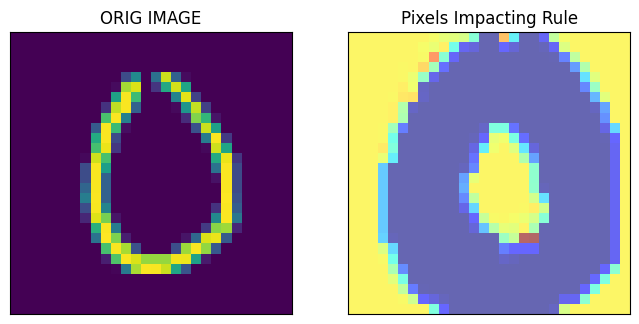

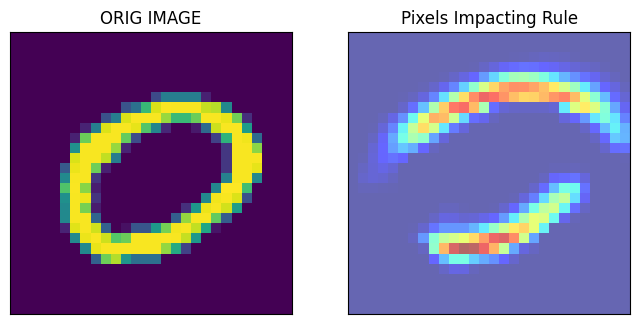

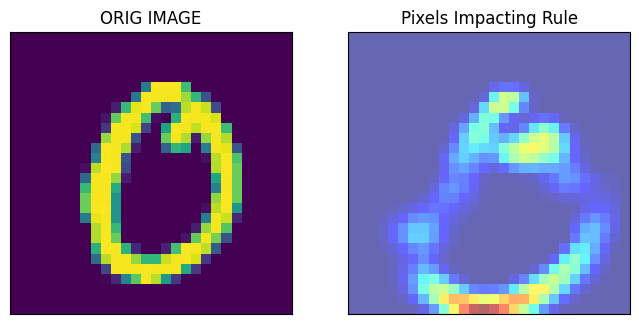

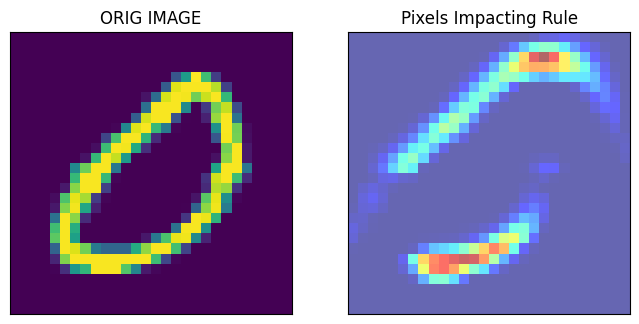

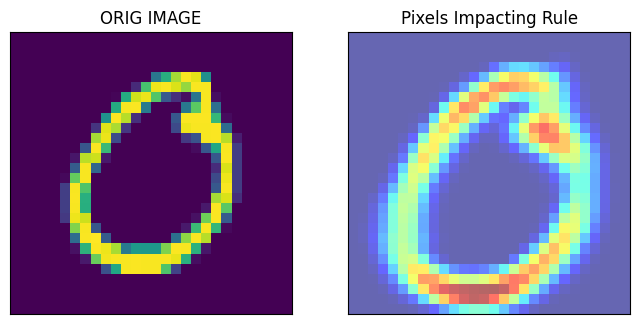

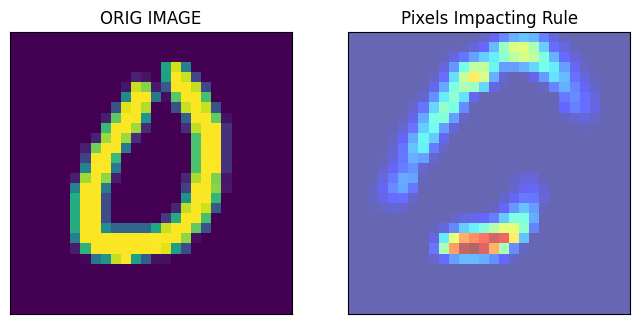

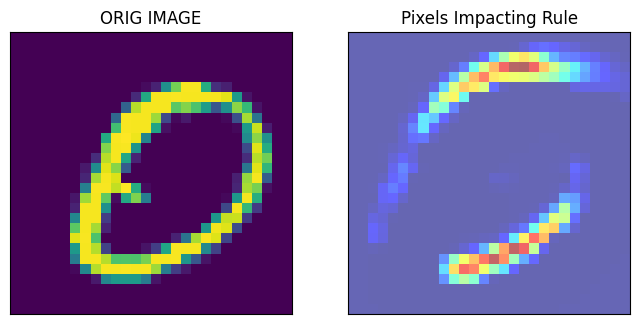

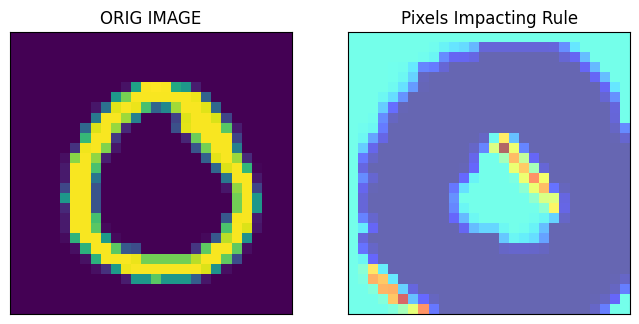

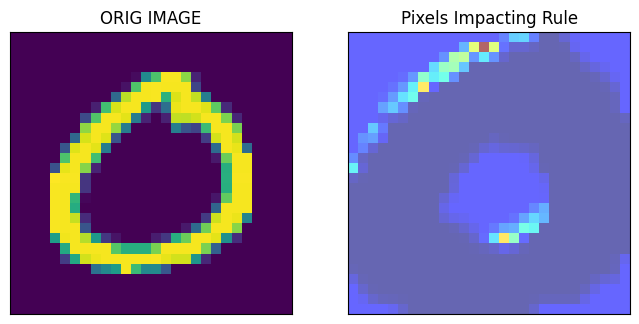

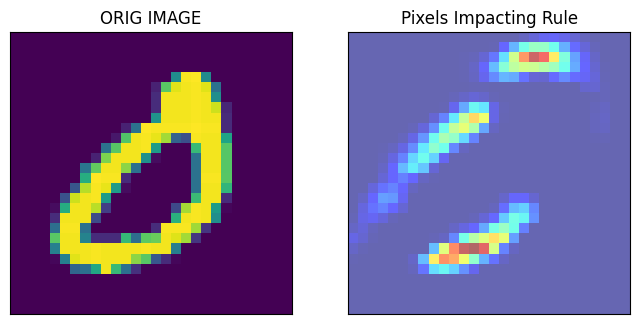

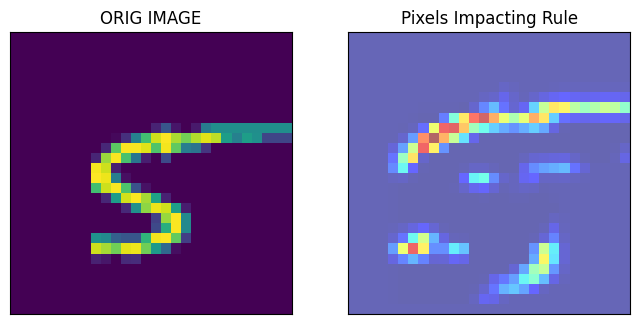

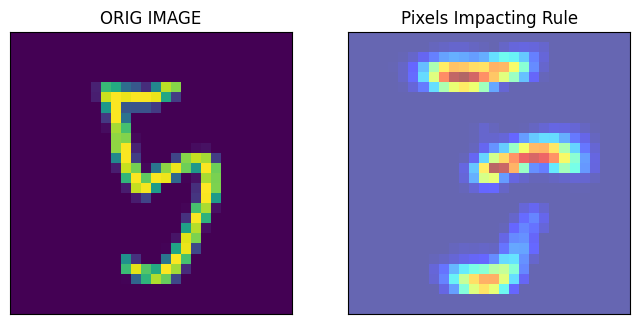

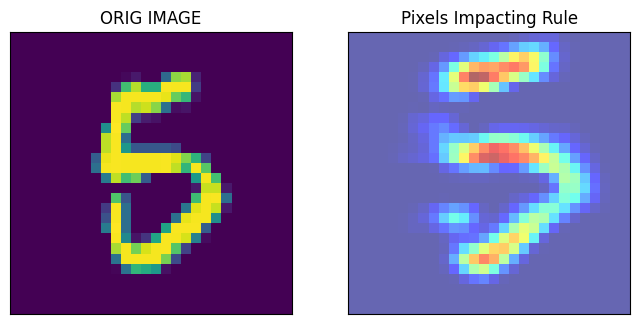

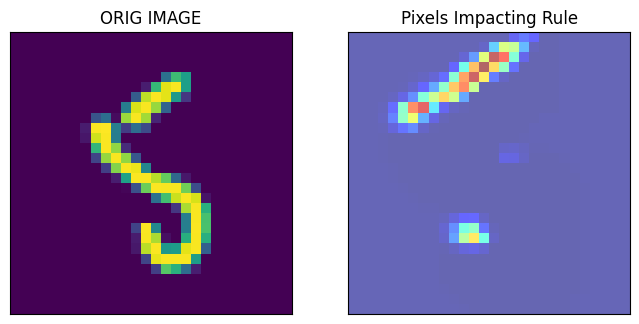

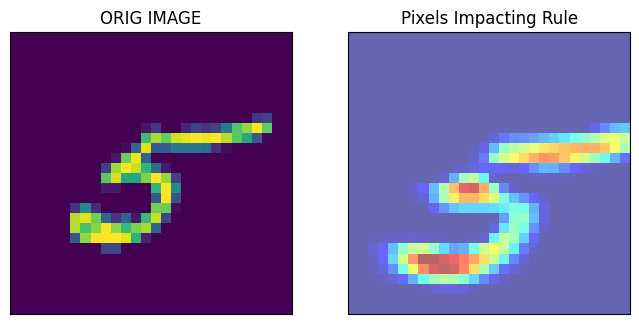

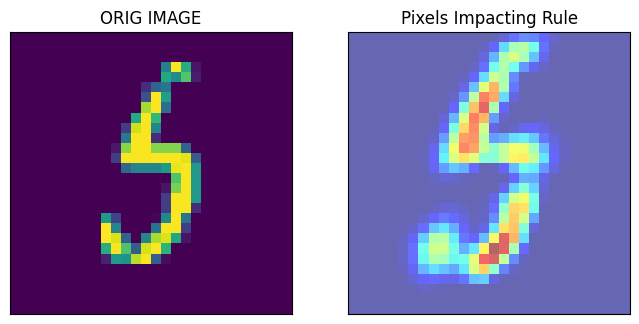

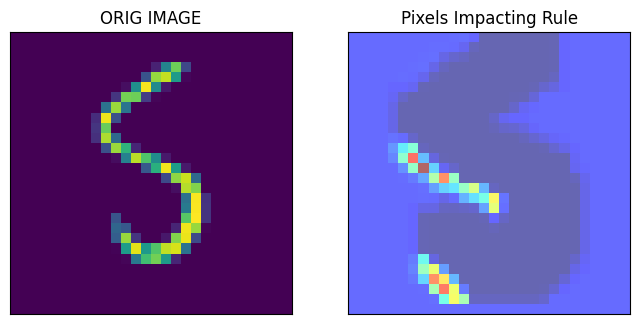

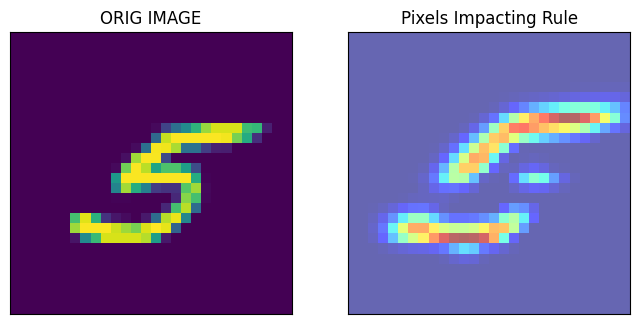

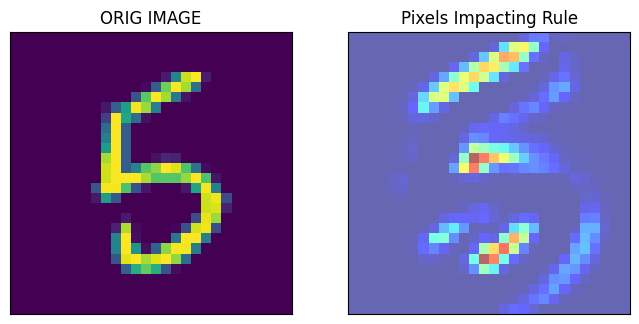

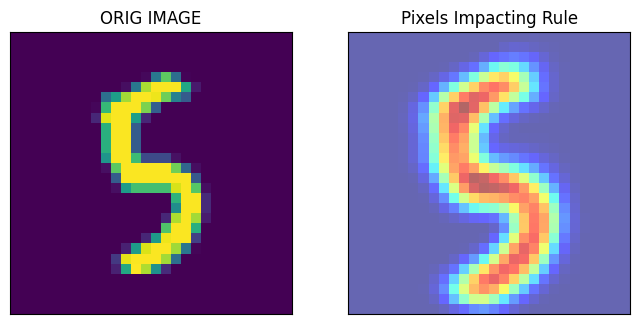

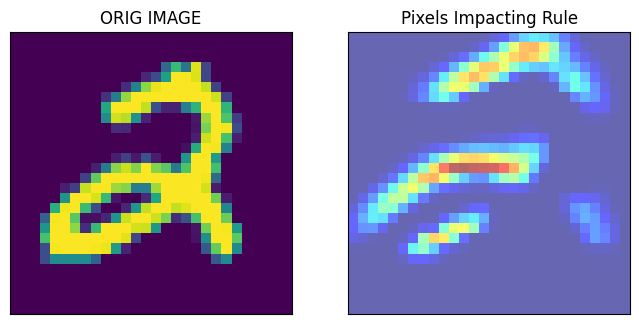

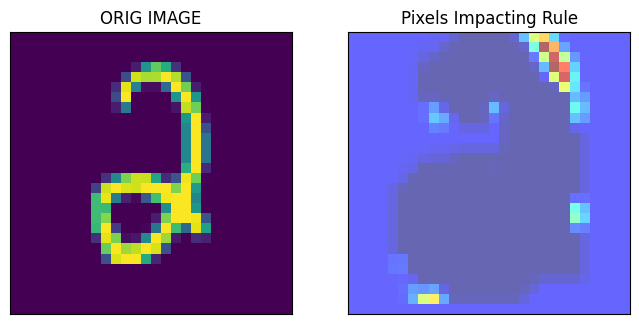

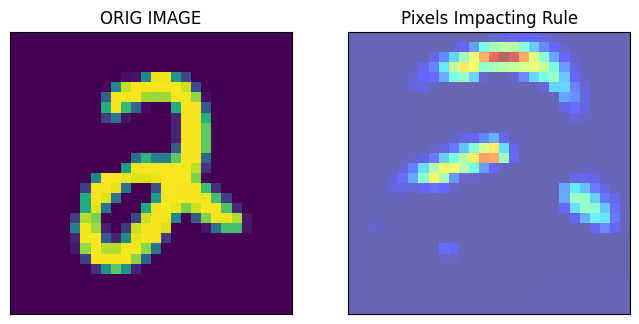

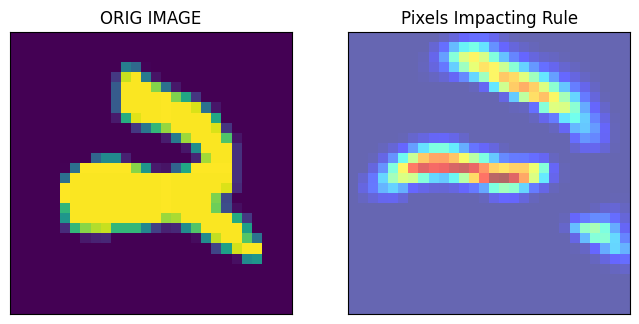

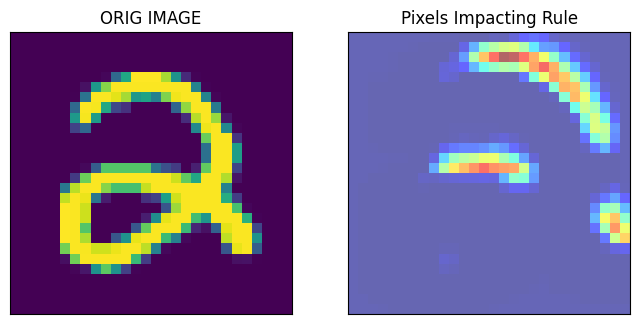

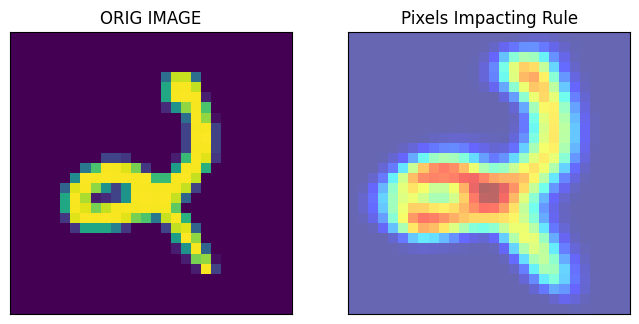

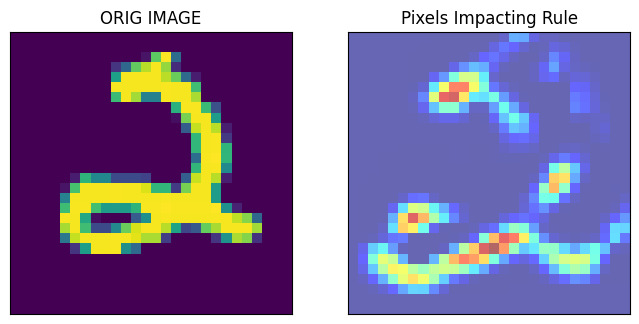

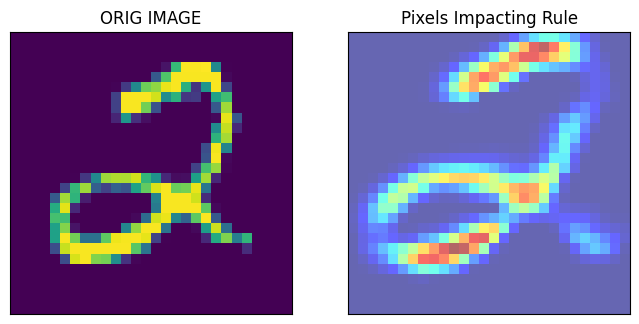

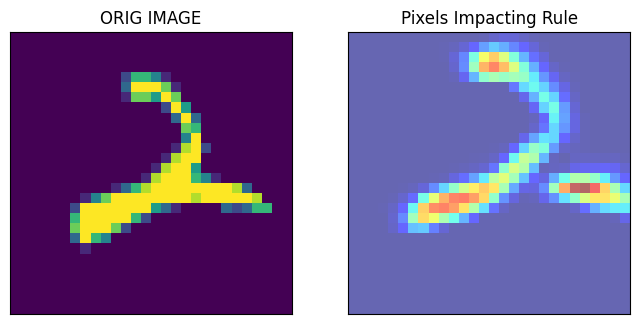

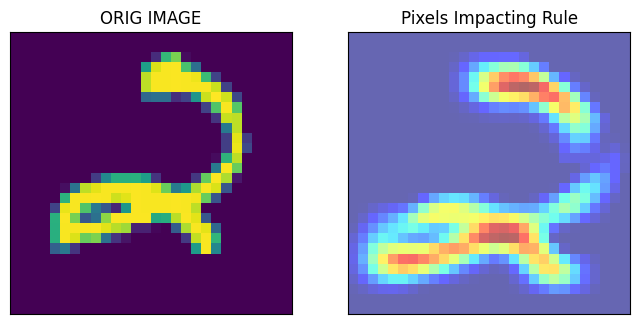

In [ ]:
print("Visualize Top Rule of Label 0 at dense_1:")
print("Highlight Pixels that impact the rule:")
inv = invariants_1[0]
print("Rule: Neurons", inv[0][0], ",Sig:", inv[0][1], ",Supp:", inv[0][2])
visualize(inv[0][0],inv[0][1],fingerprint_val_1, "dense_1")

print("Visualize Top Rule of Label 5 at dense_1:")
print("Highlight Pixels that impact the rule:")
inv = invariants_1[5]
print("Rule: Neurons", inv[5][0], ",Sig:", inv[5][1], ",Supp:", inv[5][2])
visualize(inv[5][0],inv[5][1],fingerprint_val_1, "dense_1")

print("Visualize Top Rule of Label 2 at activation_3:")
print("Highlight Pixels that impact the rule:")
inv = invariants_2a[2]
print("Rule: Neurons", inv[2][0], ",Sig:", inv[2][1], ",Supp:", inv[2][2])
visualize(inv[2][0],inv[2][1],fingerprint_act_2, "activation_3")

#**Proofs for Rules**
**Experiment with a 10 LAYER FC MNIST MODEL, which has an equivalent .NNET file (input format for Marabou)**

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


##**Define 10 layer FC Architecture in Tensor Flow**

In [19]:

def weight_variable(shape, name):
  initial = tf.compat.v1.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def fc2d(x, W):
  return tf.nn.fc2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def create_model():
    tf.compat.v1.disable_eager_execution()
    x = tf.compat.v1.identity(tf.compat.v1.placeholder(tf.float32, shape=[None, 784]), name="input")
    y_ = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.compat.v1.placeholder(tf.float32, name='keep_prob')

    W_fc1 = weight_variable([784, 10],name='w_fc1')
    b_fc1 = bias_variable([10],name='b_fc1')
    x_image = tf.reshape(x, [-1, 784])
    h_fc1_relu_inp = tf.identity(tf.matmul(x_image, W_fc1) + b_fc1, name='h_fc1_relu_inp')
    h_fc1 = tf.nn.relu(tf.matmul(x_image, W_fc1) + b_fc1)
#    h_fc1_iden = tf.identity(h_fc1,name='h_fc1')


    W_fc2 = weight_variable([10, 10],name='w_fc2')
    b_fc2 = bias_variable([10],name='b_fc2')
    h_fc2_relu_inp = tf.identity(tf.matmul(h_fc1, W_fc2) + b_fc2, name='h_fc2_relu_inp')
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
 #   h_fc2_iden = tf.identity(h_fc2,name='h_fc2')


    W_fc3 = weight_variable([10, 10],name='w_fc3')
    b_fc3 = bias_variable([10],name='b_fc3')
    h_fc3_relu_inp = tf.identity(tf.matmul(h_fc2, W_fc3) + b_fc3, name='h_fc3_relu_inp')
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
  #  h_fc3_iden = tf.identity(h_fc3,name='h_fc3')

    W_fc4 = weight_variable([10, 10],name='w_fc4')
    b_fc4 = bias_variable([10],name='b_fc4')
    h_fc4_relu_inp = tf.identity(tf.matmul(h_fc3, W_fc4) + b_fc4, name='h_fc4_relu_inp')
    h_fc4 = tf.nn.relu(tf.matmul(h_fc3, W_fc4) + b_fc4)
   # h_fc4_iden = tf.identity(h_fc4,name='h_fc4')


    W_fc5 = weight_variable([10, 10],name='w_fc5')
    b_fc5 = bias_variable([10],name='b_fc5')
    h_fc5_relu_inp = tf.identity(tf.matmul(h_fc4, W_fc5) + b_fc5, name='h_fc5_relu_inp')
    h_fc5 = tf.nn.relu(tf.matmul(h_fc4, W_fc5) + b_fc5)
    #h_fc5_iden = tf.identity(h_fc5,name='h_fc5')


    W_fc6 = weight_variable([10, 10],name='w_fc6')
    b_fc6 = bias_variable([10],name='b_fc6')
    h_fc6_relu_inp = tf.identity(tf.matmul(h_fc5, W_fc6) + b_fc6, name='h_fc6_relu_inp')
    h_fc6 = tf.nn.relu(tf.matmul(h_fc5, W_fc6) + b_fc6)
   # h_fc6_iden = tf.identity(h_fc6,name='h_fc6')


    W_fc7 = weight_variable([10, 10],name='w_fc7')
    b_fc7 = bias_variable([10],name='b_fc7')
    h_fc7_relu_inp = tf.identity(tf.matmul(h_fc6, W_fc7) + b_fc7, name='h_fc7_relu_inp')
    h_fc7 = tf.nn.relu(tf.matmul(h_fc6, W_fc7) + b_fc7)
   # h_fc7_iden = tf.identity(h_fc7,name='h_fc7')

    W_fc8 = weight_variable([10, 10],name='w_fc8')
    b_fc8 = bias_variable([10],name='b_fc8')
    h_fc8_relu_inp = tf.identity(tf.matmul(h_fc7, W_fc8) + b_fc8, name='h_fc8_relu_inp')
    h_fc8 = tf.nn.relu(tf.matmul(h_fc7, W_fc8) + b_fc8)
   # h_fc8_iden = tf.identity(h_fc8,name='h_fc8')


    W_fc9 = weight_variable([10, 10],name='w_fc9')
    b_fc9 = bias_variable([10],name='b_fc9')
    h_fc9_relu_inp = tf.identity(tf.matmul(h_fc8, W_fc9) + b_fc9, name='h_fc9_relu_inp')
    h_fc9 = tf.nn.relu(tf.matmul(h_fc8, W_fc9) + b_fc9)
   # h_fc9_iden = tf.identity(h_fc9,name='h_fc9')

    W_fc10 = weight_variable([10, 10],name='w_fc10')
    b_fc10 = bias_variable([10],name='b_fc10')
    h_fc10_relu_inp = tf.identity(tf.matmul(h_fc9, W_fc10) + b_fc10, name='h_fc10_relu_inp')
    h_fc10 = tf.nn.relu(tf.matmul(h_fc9, W_fc10) + b_fc10)
    #h_fc10_iden = tf.identity(h_fc10,name='h_fc10')

    W_fc11 = weight_variable([10, 10],name='w_fc11')
    b_fc11 = bias_variable([10],name='b_fc11')

    y_fc = tf.matmul(h_fc10, W_fc11) + b_fc11
    h_y_fc_iden = tf.identity(y_fc,name='y_fc')


    prediction = tf.identity(tf.nn.softmax(y_fc), name="import/prediction")


    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_fc))
    train_step = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_fc, 1), tf.argmax(y_, 1))


    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



    return cross_entropy, accuracy, x, keep_prob, y_fc, y_, W_fc1, W_fc2, W_fc3, W_fc4, W_fc5, W_fc6, W_fc7, W_fc8, W_fc9, W_fc10, W_fc11, b_fc1, b_fc2, b_fc3, b_fc4, b_fc5, b_fc6, b_fc7, b_fc8, b_fc9, b_fc10, b_fc11, h_fc1, h_fc1_relu_inp, h_fc2, h_fc2_relu_inp, h_fc3, h_fc3_relu_inp, h_fc4, h_fc4_relu_inp, h_fc5, h_fc5_relu_inp, h_fc6, h_fc6_relu_inp, h_fc7, h_fc7_relu_inp, h_fc8, h_fc8_relu_inp, h_fc9, h_fc9_relu_inp, h_fc10, h_fc10_relu_inp, y_fc


##**Restore pre-trained model**

In [20]:
def read_weights_from_file(inputFile):
    global weightMatrix, biasMatrix

    with open(inputFile) as f:
        lines = f.readlines()
        for indx in range(0,len(lines)):
            #print(indx, lines[indx])
            numberOfLayers = int(lines[0])
            numberOfLayers = 11
            weightMatrix = np.empty(numberOfLayers, dtype=list)
            biasMatrix = np.empty(numberOfLayers, dtype=list)
            currentLine = 2
            for i in range(numberOfLayers):
              dimensions = lines[currentLine].split(',')
              dimensions = [int(stringDimension) for stringDimension in dimensions]
              #print dimensions
              currentLine += 1
              weights = [float(stringWeight) for stringWeight in lines[currentLine].split(',')]
              #print len(weights)
              count = 0
              weightMatrix[i] = np.zeros((dimensions[0], dimensions[1]), dtype=float)
              for j in range(dimensions[1]):
                 for k in range(dimensions[0]):
                      weightMatrix[i][k][j] = weights[count]
                      count += 1
              currentLine += 1
              biases = [float(stringBias) for stringBias in lines[currentLine].split(',')]
              biasMatrix[i] = np.zeros(len(biases))
              biasMatrix[i] = biases
              currentLine += 2

!wget https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/mnist_10_layer.txt -O ./mnist_10_layer.txt


read_weights_from_file('./mnist_10_layer.txt')

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

mnist_test_images = []
for indx in range(0,len(x_test)):
   test_image = (x_test[indx]).flatten()
   mnist_test_images.append(test_image)

cross_entropy, accuracy, x, keep_prob, y_fc, y_, W_fc1, W_fc2, W_fc3, W_fc4, W_fc5, W_fc6, W_fc7, W_fc8, W_fc9, W_fc10, W_fc11,b_fc1, b_fc2, b_fc3, b_fc4, b_fc5, b_fc6, b_fc7, b_fc8, b_fc9, b_fc10, b_fc11, h_fc1, h_fc1_relu_inp, h_fc2, h_fc2_relu_inp, h_fc3, h_fc3_relu_inp,h_fc4, h_fc4_relu_inp, h_fc5, h_fc5_relu_inp, h_fc6, h_fc6_relu_inp, h_fc7, h_fc7_relu_inp, h_fc8, h_fc8_relu_inp, h_fc9, h_fc9_relu_inp, h_fc10, h_fc10_relu_inp, y_fc = create_model()

feed_dict = {x:mnist_test_images, y_: np.eye(10)[y_test], keep_prob: 1.0, W_fc1: weightMatrix[0], b_fc1: biasMatrix[0], W_fc2: weightMatrix[1], b_fc2: biasMatrix[1], W_fc3: weightMatrix[2], b_fc3: biasMatrix[2], W_fc4: weightMatrix[3], b_fc4: biasMatrix[3], W_fc5: weightMatrix[4], b_fc5: biasMatrix[4], W_fc6: weightMatrix[5], b_fc6: biasMatrix[5],W_fc7: weightMatrix[6], b_fc7: biasMatrix[6],W_fc8: weightMatrix[7], b_fc8: biasMatrix[7],W_fc9: weightMatrix[8], b_fc9: biasMatrix[8], W_fc10: weightMatrix[9], b_fc10: biasMatrix[9], W_fc11: weightMatrix[10], b_fc11: biasMatrix[10]}

test_accuracy = accuracy.eval(feed_dict)
print("Test accuracy %g"%(test_accuracy))



--2023-09-25 15:08:41--  https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/mnist_10_layer.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146765 (143K) [text/plain]
Saving to: ‘./mnist_10_layer.txt’

./mnist_10_layer.tx 100%[===================>] 143.33K  --.-KB/s    in 0.08s   

2023-09-25 15:08:42 (1.67 MB/s) - ‘./mnist_10_layer.txt’ saved [146765/146765]



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Test accuracy 0.6745


##**Get tensors from pre-trained model**

In [21]:
#cross_entropy, accuracy, x, keep_prob, y_fc, y_, W_fc1, W_fc2, W_fc3, W_fc4, W_fc5, W_fc6, W_fc7, W_fc8, W_fc9, W_fc10, W_fc11,b_fc1, b_fc2, b_fc3, b_fc4, b_fc5, b_fc6, b_fc7, b_fc8, b_fc9, b_fc10, b_fc11, h_fc1, h_fc2, h_fc2_relu_inp, h_fc3, h_fc3_relu_inp,h_fc4, h_fc4_relu_inp, h_fc5, h_fc5_relu_inp, h_fc6, h_fc7, h_fc8, h_fc9, h_fc10, y_fc = create_model()

cross_entropy, accuracy, x, keep_prob, y_fc, y_, W_fc1, W_fc2, W_fc3, W_fc4, W_fc5, W_fc6, W_fc7, W_fc8, W_fc9, W_fc10, W_fc11,b_fc1, b_fc2, b_fc3, b_fc4, b_fc5, b_fc6, b_fc7, b_fc8, b_fc9, b_fc10, b_fc11, h_fc1, h_fc1_relu_inp, h_fc2, h_fc2_relu_inp, h_fc3, h_fc3_relu_inp,h_fc4, h_fc4_relu_inp, h_fc5, h_fc5_relu_inp, h_fc6, h_fc6_relu_inp, h_fc7, h_fc7_relu_inp, h_fc8, h_fc8_relu_inp, h_fc9, h_fc9_relu_inp, h_fc10, h_fc10_relu_inp, y_fc = create_model()

t_fc1 = h_fc1 #sess.graph.get_tensor_by_name('h_fc1:0')
t_fc2 = h_fc2 #sess.graph.get_tensor_by_name('h_fc2:0')
t_fc3 = h_fc3 #sess.graph.get_tensor_by_name('h_fc3:0')
t_fc4 = h_fc4 #sess.graph.get_tensor_by_name('h_fc4:0')
t_fc5 = h_fc5 #sess.graph.get_tensor_by_name('h_fc5:0')
t_fc6 = h_fc6 #sess.graph.get_tensor_by_name('h_fc6:0')
t_fc7 = h_fc7 #sess.graph.get_tensor_by_name('h_fc7:0')
t_fc8 = h_fc8 #sess.graph.get_tensor_by_name('h_fc8:0')
t_fc9 = h_fc9 #sess.graph.get_tensor_by_name('h_fc9:0')
t_fc10 = h_fc10 #sess.graph.get_tensor_by_name('h_fc10:0')


t_label = tf.placeholder(tf.int32)
t_neuron_id = tf.placeholder(tf.int32)
t_grad = tf.gradients(y_fc[:, t_label], x)



In [22]:
import copy

def get_prediction(inps, tensor=y_fc, batch_size=100):
  def get_prediction_batch(batch):
    #feed = {x: np.array(batch), keep_prob:1.0}
    feed = {x: np.array(batch), keep_prob:1.0, W_fc1: weightMatrix[0], b_fc1: biasMatrix[0], W_fc2: weightMatrix[1], b_fc2: biasMatrix[1], W_fc3: weightMatrix[2], b_fc3: biasMatrix[2], W_fc4: weightMatrix[3], b_fc4: biasMatrix[3], W_fc5: weightMatrix[4], b_fc5: biasMatrix[4], W_fc6: weightMatrix[5], b_fc6: biasMatrix[5],W_fc7: weightMatrix[6], b_fc7: biasMatrix[6],W_fc8: weightMatrix[7], b_fc8: biasMatrix[7],W_fc9: weightMatrix[8], b_fc9: biasMatrix[8], W_fc10: weightMatrix[9], b_fc10: biasMatrix[9], W_fc11: weightMatrix[10], b_fc11: biasMatrix[10]}
    return sess.run(tensor, feed_dict=feed)
  n = len(inps)
  if n%batch_size == 0:
    batches = [inps[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size))]
  else:
    batches = [inps[i*batch_size:(i+1)*batch_size] for i in range(int(n/batch_size) +1)]
  batch_predictions = [get_prediction_batch(b) for b in tqdm(batches)]
  return np.concatenate(tuple(batch_predictions), axis=0)

def attribute(inp, label, baseline=None, steps=50, use_top_label=False):
  def top_label(inp):
    return np.argmax(get_prediction([inp])[0])
  if baseline is None:
    baseline = 0*inp
  scaled_inputs = [baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps)]
  #feed = {keep_prob:1.0}
  feed = {keep_prob:1.0, W_fc1: weightMatrix[0], b_fc1: biasMatrix[0], W_fc2: weightMatrix[1], b_fc2: biasMatrix[1], W_fc3: weightMatrix[2], b_fc3: biasMatrix[2], W_fc4: weightMatrix[3], b_fc4: biasMatrix[3], W_fc5: weightMatrix[4], b_fc5: biasMatrix[4], W_fc6: weightMatrix[5], b_fc6: biasMatrix[5],W_fc7: weightMatrix[6], b_fc7: biasMatrix[6],W_fc8: weightMatrix[7], b_fc8: biasMatrix[7],W_fc9: weightMatrix[8], b_fc9: biasMatrix[8], W_fc10: weightMatrix[9], b_fc10: biasMatrix[9], W_fc11: weightMatrix[10], b_fc11: biasMatrix[10]}

  if use_top_label:
    feed[x] = [inp]
    logits = sess.run(y_fc, feed_dict=feed)[0]
    label = np.argmax(logits)
  feed[x] = scaled_inputs
  feed[t_label] = label
  grads, scores = sess.run([t_grad, y_fc], feed_dict=feed)  # shapes: <steps+1>, <steps+1, inp.shape>
  integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
#  print "FINAL SCORE", scores[-1][label]
#  print "BASELINE SCORE", scores[0][label]
#  print "SUM", np.sum(integrated_gradients), "DIFF", scores[-1][label] - scores[0][label]
  return integrated_gradients

def conductance(inp, label, neuron_id=None, baseline=None, steps=50,LAYER=1):
  # neuron_id is the id of the neuron in layer t_fc1 through which conductance
  # must be computed. If None, vanilla IG is computed.
  curr_hlay = h_fc1
  if (LAYER == 1):
      curr_lay = h_fc1
      inp_lay = h_fc1_relu_inp
  if (LAYER == 2):
      curr_lay = h_fc2
      inp_lay = h_fc2_relu_inp
  if (LAYER == 3):
      curr_lay = h_fc3
      inp_lay = h_fc3_relu_inp
  if (LAYER == 4):
      curr_lay = h_fc4
      inp_lay = h_fc4_relu_inp
  if (LAYER == 5):
      curr_lay = h_fc5
      inp_lay = h_fc5_relu_inp
  if (LAYER == 6):
      curr_lay = h_fc6
      inp_lay = h_fc6_relu_inp
  if (LAYER == 7):
      curr_lay = h_fc7
      inp_lay = h_fc7_relu_inp
  if (LAYER == 8):
      curr_lay = h_fc8
      inp_lay = h_fc8_relu_inp
  if (LAYER == 9):
      curr_lay = h_fc9
      inp_lay = h_fc9_relu_inp
  if (LAYER == 10):
      curr_lay = h_fc10
      inp_lay = h_fc10_relu_inp


  t_grad_neuron = tf.gradients(y_fc[:, t_label], curr_hlay)[0]
  t_grad_conductance = tf.gradients(inp_lay[:,t_neuron_id], x, grad_ys=t_grad_neuron[:, t_neuron_id])
  if baseline is None:
    baseline = 0*inp
  scaled_inputs = [baseline + (float(i)/steps)*(inp-baseline) for i in range(0, steps)]
  feed = {keep_prob:1.0, W_fc1: weightMatrix[0], b_fc1: biasMatrix[0], W_fc2: weightMatrix[1], b_fc2: biasMatrix[1], W_fc3: weightMatrix[2], b_fc3: biasMatrix[2], W_fc4: weightMatrix[3], b_fc4: biasMatrix[3], W_fc5: weightMatrix[4], b_fc5: biasMatrix[4], W_fc6: weightMatrix[5], b_fc6: biasMatrix[5],W_fc7: weightMatrix[6], b_fc7: biasMatrix[6],W_fc8: weightMatrix[7], b_fc8: biasMatrix[7],W_fc9: weightMatrix[8], b_fc9: biasMatrix[8], W_fc10: weightMatrix[9], b_fc10: biasMatrix[9], W_fc11: weightMatrix[10], b_fc11: biasMatrix[10]}
  feed[x] = scaled_inputs
  feed[t_label] = label
  if neuron_id != None:
    feed[t_neuron_id] = neuron_id
    grads, scores = sess.run([t_grad_conductance, y_fc], feed_dict=feed)  # shapes: <steps+1>, <steps+1, inp.shape>
    integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
    return integrated_gradients
  grads, scores = sess.run([t_grad, y_fc], feed_dict=feed)  # shapes: <steps+1>, <steps+1, inp.shape>
  integrated_gradients = (inp-baseline)*np.average(grads[0], axis=0)  # shape: <inp.shape>
  #print "FINAL SCORE", scores[-1][label]
  #print "BASELINE SCORE", scores[0][label]
  #print "SUM", np.sum(integrated_gradients), "DIFF", scores[-1][label] - scores[0][label]
  return integrated_gradients

##**Extracting Rules**

In [23]:
def fingerprint_suffix(inps):
  # Below t_fc1 is the final fully connected layer of size 1024.
  return (get_prediction(inps, tensor=t_fc6)>0.0).astype('int')

def fingerprint_signature(inps,ten = t_fc1):
  # Below t_fc1 is the final fully connected layer of size 1024.
  return (get_prediction(inps, tensor=ten)>0.0).astype('int')

def fingerprint_prefix(inps):
  return (get_prediction(inps, tensor=tf.reshape(t_fc1, [-1, 14*14*32]))>0.0).astype('int')

In [24]:

mnist_train_images = []
for indx in range(0,len(x_train)):
   train_image = (x_train[indx]).flatten()
   mnist_train_images.append(train_image)

fingerprint_act_1 = fingerprint_signature(mnist_train_images, t_fc1)
fingerprint_act_2 = fingerprint_signature(mnist_train_images, t_fc2)
fingerprint_act_3 = fingerprint_signature(mnist_train_images, t_fc3)
fingerprint_act_4 = fingerprint_signature(mnist_train_images, t_fc4)
fingerprint_act_5 = fingerprint_signature(mnist_train_images, t_fc5)
fingerprint_act_6 = fingerprint_signature(mnist_train_images, t_fc6)
fingerprint_act_7 = fingerprint_signature(mnist_train_images, t_fc7)
fingerprint_act_8 = fingerprint_signature(mnist_train_images, t_fc8)
fingerprint_act_9 = fingerprint_signature(mnist_train_images, t_fc9)
fingerprint_act_10 = fingerprint_signature(mnist_train_images, t_fc10)


train_labels = np.argmax(get_prediction(mnist_train_images), axis=1)

print(train_labels.shape,y_train.shape)

train_corr = [i for i in (np.where(train_labels == y_train)[0])]
print("CORRECT:",len(train_corr))
train_incorr = [i for i in (np.where(train_labels != y_train)[0])]
print("INCORRECT:",len(train_incorr))

for indx in train_incorr:
  train_labels[indx] = 1000

print("Accuracy:" , (len(train_corr) / (len(train_corr)+len(train_incorr)) * 100.0))


100%|██████████| 600/600 [00:01<00:00, 346.95it/s]


(60000,) (60000,)
CORRECT: 40292
INCORRECT: 19708
Accuracy: 67.15333333333334


In [25]:
print(fingerprint_act_1.shape, train_labels.shape)
basic_estimator1 = tree.DecisionTreeClassifier()
basic_estimator1.fit(fingerprint_act_1, train_labels)

print(fingerprint_act_2.shape, train_labels.shape)
basic_estimator2 = tree.DecisionTreeClassifier()
basic_estimator2.fit(fingerprint_act_2, train_labels)

print(fingerprint_act_3.shape, train_labels.shape)
basic_estimator3 = tree.DecisionTreeClassifier()
basic_estimator3.fit(fingerprint_act_3, train_labels)

print(fingerprint_act_4.shape, train_labels.shape)
basic_estimator4 = tree.DecisionTreeClassifier()
basic_estimator4.fit(fingerprint_act_4, train_labels)

print(fingerprint_act_5.shape, train_labels.shape)
basic_estimator5 = tree.DecisionTreeClassifier()
basic_estimator5.fit(fingerprint_act_5, train_labels)

print(fingerprint_act_6.shape, train_labels.shape)
basic_estimator6 = tree.DecisionTreeClassifier()
basic_estimator6.fit(fingerprint_act_6, train_labels)

print(fingerprint_act_7.shape, train_labels.shape)
basic_estimator7 = tree.DecisionTreeClassifier()
basic_estimator7.fit(fingerprint_act_7, train_labels)

print(fingerprint_act_8.shape, train_labels.shape)
basic_estimator8 = tree.DecisionTreeClassifier()
basic_estimator8.fit(fingerprint_act_8, train_labels)

print(fingerprint_act_9.shape, train_labels.shape)
basic_estimator9 = tree.DecisionTreeClassifier()
basic_estimator9.fit(fingerprint_act_9, train_labels)

print(fingerprint_act_10.shape, train_labels.shape)
basic_estimator10 = tree.DecisionTreeClassifier()
basic_estimator10.fit(fingerprint_act_10, train_labels)



(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)
(60000, 10) (60000,)


DecisionTreeClassifier()

In [26]:
fingerprints_val_tr = []
fingerprints_val_tst = []
fingerprints_act_tr = []
fingerprints_act_tst = []


fingerprints_act_tr.append(fingerprint_act_1)
fingerprints_act_tr.append(fingerprint_act_2)
fingerprints_act_tr.append(fingerprint_act_3)
fingerprints_act_tr.append(fingerprint_act_4)
fingerprints_act_tr.append(fingerprint_act_5)
fingerprints_act_tr.append(fingerprint_act_6)
fingerprints_act_tr.append(fingerprint_act_7)
fingerprints_act_tr.append(fingerprint_act_8)
fingerprints_act_tr.append(fingerprint_act_9)
fingerprints_act_tr.append(fingerprint_act_10)

labels = train_labels

In [27]:
invariants_1 = get_all_invariants(basic_estimator1)
invariants_2 = get_all_invariants(basic_estimator2)
invariants_3 = get_all_invariants(basic_estimator3)
invariants_4 = get_all_invariants(basic_estimator4)
invariants_5 = get_all_invariants(basic_estimator5)
invariants_6 = get_all_invariants(basic_estimator6)
invariants_7 = get_all_invariants(basic_estimator7)
invariants_8 = get_all_invariants(basic_estimator8)
invariants_9 = get_all_invariants(basic_estimator9)
invariants_10 = get_all_invariants(basic_estimator10)

print("RULES FROM LAYER 1 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_1,1,ALL=False,Top=True,MIS=True)
print("RULES FROM LAYER 2 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_2,2,ALL=False,Top=True,MIS=True)

print("RULES FROM LAYER 3 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_3,3,ALL=False,Top=True,MIS=True)
print("RULES FROM LAYER 4 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_4,4,ALL=False,Top=True,MIS=True)

print("RULES FROM LAYER 5 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_5,5,ALL=False,Top=True,MIS=True)
print("RULES FROM LAYER 6 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_6,6,ALL=False,Top=True,MIS=True)

print("RULES FROM LAYER 7 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_7,7,ALL=False,Top=True,MIS=True)
print("RULES FROM LAYER 8 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_8,8,ALL=False,Top=True,MIS=True)

print("RULES FROM LAYER 9 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_9,9,ALL=False,Top=True,MIS=True)
print("RULES FROM LAYER 10 IN TERMS OF NEURON ACTIVATIONS.")
describe_invariants_all_labels(invariants_10,10,ALL=False,Top=True,MIS=True)




Obtained all paths


100%|██████████| 580/580 [00:00<00:00, 422196.52it/s]


Obtained all paths


100%|██████████| 259/259 [00:00<00:00, 470474.12it/s]


Obtained all paths


100%|██████████| 147/147 [00:00<00:00, 395739.85it/s]


Obtained all paths


100%|██████████| 89/89 [00:00<00:00, 355856.11it/s]


Obtained all paths


100%|██████████| 47/47 [00:00<00:00, 278042.72it/s]


Obtained all paths


100%|██████████| 60/60 [00:00<00:00, 351477.99it/s]


Obtained all paths


100%|██████████| 50/50 [00:00<00:00, 274856.09it/s]


Obtained all paths


100%|██████████| 36/36 [00:00<00:00, 200524.49it/s]


Obtained all paths


100%|██████████| 58/58 [00:00<00:00, 324359.51it/s]


Obtained all paths


100%|██████████| 54/54 [00:00<00:00, 249440.99it/s]

RULES FROM LAYER 1 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:1, NEURONS:[0, 3, 4, 7, 9, 8, 2, 5, 6, 1], SIGNATURE:[1, 0, 1, 0, 0, 0, 1, 0, 0, 0], SUPPORT:350",100,1.775929


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 3,"LAYER:1, NEURONS:[0, 3, 6, 1, 7, 8, 2, 4, 9, 5], SIGNATURE:[1, 1, 1, 0, 0, 0, 1, 0, 0, 1], SUPPORT:11",100,0.187043


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 5,"LAYER:1, NEURONS:[0, 7, 1, 5, 8, 9, 2, 3], SIGNATURE:[0, 0, 0, 0, 0, 1, 0, 1], SUPPORT:23",100,0.534387


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 4,"LAYER:1, NEURONS:[0, 3, 6, 8, 1, 2, 5, 7, 9, 4], SIGNATURE:[1, 1, 0, 1, 0, 0, 0, 0, 1, 1], SUPPORT:6",100,0.147783


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 2,"LAYER:1, NEURONS:[0, 7, 1, 2, 5, 9, 4, 6, 8, 3], SIGNATURE:[0, 0, 1, 0, 0, 0, 0, 0, 0, 1], SUPPORT:19",100,0.338379


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 0,"LAYER:1, NEURONS:[0, 7, 2, 8, 1, 5, 9, 4, 3, 6], SIGNATURE:[0, 1, 0, 0, 0, 1, 1, 0, 0, 1], SUPPORT:4",100,0.069529


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 7,"LAYER:1, NEURONS:[0, 3, 4, 1, 2, 9, 6, 8, 7], SIGNATURE:[1, 0, 0, 1, 0, 1, 1, 1, 1], SUPPORT:5",100,0.089063


RULES FROM LAYER 2 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:2, NEURONS:[3, 2, 4, 0, 8, 6, 1], SIGNATURE:[0, 0, 0, 0, 0, 0, 0], SUPPORT:5371",100,27.252892


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 9,"LAYER:2, NEURONS:[3, 2, 4, 0, 8, 9, 6, 5, 1, 7], SIGNATURE:[0, 0, 0, 0, 1, 0, 0, 0, 1, 0], SUPPORT:3",100,0.066919


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 5,"LAYER:2, NEURONS:[3, 8, 5, 0, 2, 4, 9, 7], SIGNATURE:[1, 1, 0, 1, 0, 1, 1, 0], SUPPORT:54",100,1.254647


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:2, NEURONS:[3, 2, 4, 1, 6, 5, 0, 9], SIGNATURE:[0, 0, 1, 1, 0, 1, 0, 1], SUPPORT:3",100,0.066313


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 4,"LAYER:2, NEURONS:[3, 2, 4, 1, 8, 5, 0, 7], SIGNATURE:[0, 0, 1, 0, 1, 0, 0, 0], SUPPORT:129",100,3.177340


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 2,"LAYER:2, NEURONS:[3, 8, 5, 6, 1, 2, 4, 0], SIGNATURE:[1, 1, 1, 0, 0, 1, 0, 1], SUPPORT:23",100,0.409617


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 7,"LAYER:2, NEURONS:[3, 8, 5, 6, 1, 2, 0, 7, 4], SIGNATURE:[1, 1, 1, 0, 1, 0, 0, 0, 0], SUPPORT:11",100,0.195939


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 3,"LAYER:2, NEURONS:[3, 8, 4, 1, 7, 2, 6, 5, 0], SIGNATURE:[1, 0, 0, 1, 0, 1, 1, 0, 0], SUPPORT:4",100,0.068016


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 0,"LAYER:2, NEURONS:[3, 8, 4, 1, 7, 2], SIGNATURE:[1, 0, 0, 1, 0, 0], SUPPORT:67",100,1.164610


RULES FROM LAYER 3 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:3, NEURONS:[1, 3, 4, 2, 7, 6, 5, 9, 0], SIGNATURE:[0, 0, 0, 0, 1, 0, 0, 0, 0], SUPPORT:221",100,1.121372


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 4,"LAYER:3, NEURONS:[1, 3, 9, 4, 0, 6, 2], SIGNATURE:[0, 1, 0, 0, 1, 1, 1], SUPPORT:176",100,4.334975


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 0,"LAYER:3, NEURONS:[1, 4, 9, 5, 3, 7, 6, 0, 8], SIGNATURE:[1, 0, 1, 1, 0, 0, 0, 0, 1], SUPPORT:31",100,0.538849


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:3, NEURONS:[1, 4, 0, 6, 9, 2, 3], SIGNATURE:[1, 1, 1, 1, 0, 1, 0], SUPPORT:4",100,0.088417


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 7,"LAYER:3, NEURONS:[1, 4, 0, 8, 6, 9, 3, 5], SIGNATURE:[1, 1, 0, 0, 1, 1, 1, 1], SUPPORT:13",100,0.231564


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 5,"LAYER:3, NEURONS:[1, 4, 0, 6, 3, 7, 5, 9], SIGNATURE:[1, 1, 1, 0, 1, 0, 1, 0], SUPPORT:181",100,4.205390


RULES FROM LAYER 4 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:4, NEURONS:[3, 5, 8, 1, 2, 6], SIGNATURE:[0, 0, 0, 1, 0, 0], SUPPORT:3",100,0.015222


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 4,"LAYER:4, NEURONS:[3, 5, 0, 8, 7, 9, 4, 6], SIGNATURE:[0, 1, 1, 0, 0, 0, 1, 1], SUPPORT:487",100,11.995074


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 0,"LAYER:4, NEURONS:[3, 0, 9, 1, 7, 6], SIGNATURE:[1, 1, 0, 0, 1, 0], SUPPORT:3",100,0.052147


RULES FROM LAYER 5 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:5, NEURONS:[4, 7, 0, 1, 2, 8], SIGNATURE:[0, 1, 0, 0, 1, 1], SUPPORT:12",100,0.060889


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 5,"LAYER:5, NEURONS:[4, 1, 5, 3], SIGNATURE:[1, 0, 0, 0], SUPPORT:1",100,0.023234


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:5, NEURONS:[4, 1, 5, 3, 8, 7], SIGNATURE:[1, 1, 1, 0, 1, 1], SUPPORT:2",100,0.044209


RULES FROM LAYER 6 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:6, NEURONS:[6, 4, 8, 9, 2, 5, 1], SIGNATURE:[1, 1, 0, 0, 1, 0, 1], SUPPORT:42",100,0.213111


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 4,"LAYER:6, NEURONS:[6, 2, 7, 4, 9, 0, 8], SIGNATURE:[0, 1, 0, 1, 1, 1, 1], SUPPORT:368",100,9.064039


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 5,"LAYER:6, NEURONS:[6, 4, 5, 1, 2, 0, 3], SIGNATURE:[1, 0, 1, 1, 0, 1, 1], SUPPORT:17",100,0.394981


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:6, NEURONS:[6, 4, 8, 9, 2], SIGNATURE:[1, 1, 0, 0, 0], SUPPORT:1",100,0.022104


RULES FROM LAYER 7 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:7, NEURONS:[6, 1, 5, 7], SIGNATURE:[0, 0, 0, 0], SUPPORT:353",100,1.791151


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:7, NEURONS:[6, 1, 5, 7, 9, 3, 4, 2], SIGNATURE:[0, 0, 1, 1, 1, 1, 0, 1], SUPPORT:2",100,0.044209


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 8,"LAYER:7, NEURONS:[6, 1, 3, 5, 0, 7, 9, 2], SIGNATURE:[0, 1, 1, 1, 1, 1, 0, 0], SUPPORT:1",100,12.500000


RULES FROM LAYER 8 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:8, NEURONS:[8, 3, 6, 7, 1, 5, 0], SIGNATURE:[1, 1, 0, 1, 1, 1, 0], SUPPORT:126",100,0.639334


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:8, NEURONS:[8, 3, 6, 7, 1, 5, 0], SIGNATURE:[1, 1, 0, 1, 1, 0, 0], SUPPORT:1",100,0.022104


RULES FROM LAYER 9 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:9, NEURONS:[2, 1, 7, 9, 4, 8, 0, 3], SIGNATURE:[0, 1, 1, 1, 0, 1, 1, 0], SUPPORT:2",100,0.010148


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 7,"LAYER:9, NEURONS:[2, 0, 9, 6, 8, 3, 1, 7], SIGNATURE:[1, 1, 0, 0, 1, 0, 0, 0], SUPPORT:1",100,0.017813


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:9, NEURONS:[2, 0, 9, 8, 6, 3, 7], SIGNATURE:[1, 1, 1, 1, 0, 1, 1], SUPPORT:1",100,0.022104


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 0,"LAYER:9, NEURONS:[2, 0, 9, 8, 6, 3], SIGNATURE:[1, 1, 1, 1, 1, 1], SUPPORT:14",100,0.243351


RULES FROM LAYER 10 IN TERMS OF NEURON ACTIVATIONS.
PRINTING RULES WITH HIGHEST RECALL FOR CORRECT CLASSIFICATION TO EVERY LABEL.
PRINTING RULES WITH HIGHEST RECALL FOR INCORRECT CLASSIFICATION.


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for incorrect classification,"LAYER:10, NEURONS:[0, 7, 2, 8, 3, 5, 4], SIGNATURE:[1, 1, 1, 1, 1, 0, 0], SUPPORT:204",100,1.035113


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 2,"LAYER:10, NEURONS:[0, 4, 3, 5, 8, 2, 9], SIGNATURE:[0, 1, 0, 1, 0, 0, 1], SUPPORT:7",100,0.124666


Rule Type,Rule,Train Precision (%),Train Recall (%)
Rule for correct classification to 6,"LAYER:10, NEURONS:[0, 4, 3, 5, 9], SIGNATURE:[0, 1, 1, 1, 1], SUPPORT:4",100,0.088417


##**Check Rules using Marabou**

In [58]:
!wget https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/marabou1.elf -O ./marabou1.elf
!wget https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/mnist_10_layer.nnet -O ./mnist_10_layer.nnet
!pwd
!ls -lt ./marabou1.elf
!chmod 777 ./marabou1.elf
!ls -lt ./marabou1.elf

--2023-09-25 13:03:56--  https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/marabou1.elf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4231816 (4.0M) [application/octet-stream]
Saving to: ‘./marabou1.elf’

./marabou1.elf      100%[===================>]   4.04M  --.-KB/s    in 0.06s   

2023-09-25 13:03:57 (71.0 MB/s) - ‘./marabou1.elf’ saved [4231816/4231816]

--2023-09-25 13:03:57--  https://raw.githubusercontent.com/safednn-nasa/Prophecy/master/2023/mnist_10_layer.nnet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [59]:
def invoke_marabou_chk(layer,neurons,signature,label):
  #layer = 1
  #neurons = [4, 8, 7, 1, 0, 2, 5, 3, 9, 6]
  #signature = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  #label = 6

  for lab_indx in range(0,10):
    if (lab_indx == label):
      continue
    strInp = ""
    for i in range(0,784):
      strInp = strInp + "x"+ str(i) + " >= 0.0" + "\n"
      #strInp = strInp + "x"+ str(i) + " <= 1.0" + "\n"
    #print(strInp)

    strInternal = ""
    for i in range(0,len(neurons)):
      strInternal = strInternal + "ws_"+ str(layer) + "_" + str(neurons[i])
      if (signature[i] == 0):
         strInternal = strInternal + " <= 0.0" + "\n"
      else:
         strInternal = strInternal + " >= 0.0"  + "\n"

    strOP = "-y"+ str(lab_indx) + " +y" + str(label) + " <= 0.00" + "\n" ## Is op_label < op_other?

    #Write to a property file
    file1 = open('property.txt',"w")
    #file1.writelines(strInp)
    file1.writelines(strInternal)
    file1.writelines(strOP)
    file1.close()

    file1 = open('property.txt',"r")
    print("PROPERTY FILE IS ")
    print(file1.read())
    file1.close()

    !./marabou1.elf ./mnist_10_layer.nnet ./property.txt --summary-file=summary1.txt
    print("SUMMARY:")
    f = open('summary1.txt', 'r')
    file_contents = f.read()
    print (file_contents)
    f.close()
    if (file_contents.find('UNSAT') == -1): ## UNSAT is not found, SAT is found, =>  op_label > op_other then break "Unable to Prove"
        print("UNABLE TO PROVE:")
        break
  #f.close()


In [ ]:
print(invariants_4[4][0])


invoke_marabou_chk(4,invariants_4[4][0][0],invariants_4[4][0][1],4)

Streaming output truncated to the last 5000 lines.
	Number of tightened bounds: 479635.
		Number of rows examined by row tightener: 698870. Consequent tightenings: 37659
		Number of explicit basis matrices examined by row tightener: 9766. Consequent tightenings: 254676
		Number of bound tightening rounds on the entire constraint matrix: 388. Consequent tightenings: 221504
		Number of bound notifications sent to PL constraints: 404294. Tightenings proposed: 1012013
	--- Basis Factorization statistics ---
	Number of basis refactorizations: 11328
	--- Projected Steepest Edge Statistics ---
	Number of iterations: 717379.
	Number of resets to reference space: 6328. Avg. iterations per reset: 113
	--- SBT ---
	Number of tightened bounds: 80557

08:32:09 Statistics update:
	--- Time Statistics ---
	Total time elapsed: 7759418 milli (02:09:19)
		Main loop: 7758498 milli (02:09:18)
		Preprocessing time: 517 milli (00:00:00)
		Unknown: 402 milli (00:00:00)
	Breakdown for main loop:
		[3.22%] Sim